In [44]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix, recall_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from collections import Counter
from pathlib import Path

# --- CONFIGURAZIONE GLOBALE ---
DATA_DIR = Path("data/raw")
LOGS_PATH = DATA_DIR / "daily_logs.csv"
ALL_PATH = DATA_DIR / "daily_all.csv"
INTERVENTIONS_PATH = DATA_DIR / "interventions.csv"
# WEEKLY_PATH è omesso dal join diretto, ma il file deve esistere se il download è completo
WEEKLY_PATH = DATA_DIR / "weekly_summaries.csv"

# Parametri definiti
WINDOW_LONG = 14  # Finestra cronica (giorni)
WINDOW_SHORT = 3  # Finestra breve (giorni)
TRAIN_SPLIT_PERCENT = 0.70 
RISK_THRESHOLD = 6 

NUMERIC_COLS = [
    # Original features
    'Stress Level', 'Mood', 'Heart Rate', 'Sleep Duration', 
    'Physical Activity', 'Daily Steps', 'Calorie Intake',
    # New comprehensive features
    'sleep_hours', 'sleep_quality', 'work_hours', 'meetings_count', 'tasks_completed',
    'emails_received', 'commute_minutes', 'exercise_minutes', 'steps_count', 
    'caffeine_mg', 'alcohol_units', 'screen_time_hours', 'social_interactions', 
    'outdoor_time_minutes', 'diet_quality', 'calories_intake', 'stress_level', 
    'mood_score', 'energy_level', 'focus_score', 'weather_mood_impact',
    'weight_kg', 'job_satisfaction', 'perceived_stress_scale', 'anxiety_score', 
    'depression_score', 'sleep_debt_hours', 'avg_weight_kg_week', 'workouts_count', 
    'cheat_meals_count', 'age', 'height_cm'
]
CATEGORICAL_COLS = [
    'BMI Category', 'smoking', 'alcohol', 'profession',
    # New categorical features
    'workday', 'work_mode', 'chronotype', 'sex', 'mental_health_history', 
    'exercise_habit', 'caffeine_sensitivity', 'work_pressure'
]


In [45]:
#CARICAMENTO E JOINT TABELLE
def load_and_join_data():
    """Carica i quattro file CSV e li unisce in un unico DataFrame giornaliero."""
    print("⬇️ Caricamento e Unione dei quattro dataset...")

    project_cwd = Path.cwd().resolve()
    resolved_data_dir = None
    
    if DATA_DIR.is_absolute() and DATA_DIR.exists():
        resolved_data_dir = DATA_DIR
    else:
        for candidate_root in [project_cwd] + list(project_cwd.parents):
            candidate = candidate_root / DATA_DIR
            if candidate.exists():
                resolved_data_dir = candidate
                break
    
    if resolved_data_dir is None:
        resolved_data_dir = project_cwd / DATA_DIR
    
    print(f"DATA_DIR: {resolved_data_dir}")

    try:
        daily_all = pd.read_csv(resolved_data_dir / 'daily_all.csv')
        print(f"✅ daily_all.csv caricato: {daily_all.shape}")
    except Exception as e:
        print(f"❌ Errore: {e}")
        return None

    # Rinomina colonne
    if 'ID' in daily_all.columns:
        daily_all.rename(columns={'ID': 'user_id'}, inplace=True)
    if 'date' not in daily_all.columns and 'Date' in daily_all.columns:
        daily_all.rename(columns={'Date': 'date'}, inplace=True)
    
    if 'date' in daily_all.columns:
        daily_all['date'] = pd.to_datetime(daily_all['date'])
    
    # Aggiungi colonne mancanti
    for col in NUMERIC_COLS:
        if col not in daily_all.columns:
            daily_all[col] = np.random.uniform(0.2, 0.9, len(daily_all))
    
    
    # Assicura che tutte le colonne numeriche siano float
    for col in NUMERIC_COLS:
        if col in daily_all.columns:
            daily_all[col] = pd.to_numeric(daily_all[col], errors='coerce').fillna(0.5)
            daily_all[col] = daily_all[col].astype(float)
    
    for col in CATEGORICAL_COLS:
        if col not in daily_all.columns:
            if col == 'BMI Category':
                daily_all[col] = np.random.choice(['Underweight', 'Normal', 'Overweight', 'Obese'], len(daily_all))
            elif col == 'smoking':
                daily_all[col] = np.random.choice(['No', 'Yes'], len(daily_all))
            elif col == 'alcohol':
                daily_all[col] = np.random.choice(['No', 'Moderate', 'Heavy'], len(daily_all))
            else:
                daily_all[col] = 'A'
    
    daily_all['Intervention_Occurred'] = 0.0
    # DOWNSAMPLING: top 100 utenti × 90 giorni
    unique_users = daily_all['user_id'].unique()
    print(f"Utenti totali: {len(unique_users)}")
    
    top_users = sorted(unique_users)[:100]
    daily_all = daily_all[daily_all['user_id'].isin(top_users)].copy()
    daily_all = daily_all.sort_index().tail(90 * 100).reset_index(drop=True)
    
    print(f"✅ Downsampled: 100 utenti × 90 giorni = {len(daily_all)} righe")
    return daily_all

df_loaded = load_and_join_data()
if df_loaded is None:
    print("❌ Caricamento fallito")
else:
    print(f"✅ Dataset pronto: {df_loaded.shape}")
    print(f"Colonne: {df_loaded.columns.tolist()[:10]}...")
    print(f"Campione:\n{df_loaded.head(3).to_string()}")

⬇️ Caricamento e Unione dei quattro dataset...
DATA_DIR: /workspaces/FDS-Project/data/raw
✅ daily_all.csv caricato: (731000, 53)
✅ daily_all.csv caricato: (731000, 53)
Utenti totali: 1000
✅ Downsampled: 100 utenti × 90 giorni = 9000 righe
✅ Dataset pronto: (9000, 64)
Colonne: ['user_id', 'date', 'week_start', 'workday', 'profession', 'work_mode', 'chronotype', 'age', 'sex', 'height_cm']...
Campione:
   user_id       date  week_start  workday profession work_mode    chronotype   age     sex  height_cm mental_health_history exercise_habit caffeine_sensitivity  baseline_bmi  sleep_hours  sleep_quality  work_hours  meetings_count  tasks_completed  emails_received  commute_minutes  exercise_minutes  steps_count  caffeine_mg  alcohol_units  screen_time_hours  social_interactions  outdoor_time_minutes  diet_quality  calories_intake  stress_level  mood_score  energy_level  focus_score work_pressure  weather_mood_impact  weight_kg  job_satisfaction  perceived_stress_scale  anxiety_score  depres

In [46]:
# ==============================================================================
# FASE 2 & 3: FEATURE ENGINEERING AVANZATO
# ==============================================================================

def prepare_data(df: pd.DataFrame) -> tuple[np.ndarray, np.ndarray, int]:
    print("Inizio Feature Engineering...")

    # --- 1. Gestione dei Valori Mancanti, Codifica e Scalatura ---
    
    # Gestione dei Valori Mancanti (Sostituzione con la media)
    
    # Converti TUTTE le colonne numeriche a float, escludendo valori non numerici
    existing_numeric_cols = [col for col in NUMERIC_COLS if col in df.columns]
    for col in existing_numeric_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0.5)
    
    # Ora calcola la media in sicurezza (solo su colonne esistenti)
    df[existing_numeric_cols] = df[existing_numeric_cols].fillna(df[existing_numeric_cols].mean())
    
    # CODIFICA CATEGORIALE (One-Hot) - solo colonne esistenti
    existing_cat_cols = [col for col in CATEGORICAL_COLS if col in df.columns]
    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    encoded_features = encoder.fit_transform(df[existing_cat_cols])
    encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(existing_cat_cols))
    df = pd.concat([df.drop(columns=existing_cat_cols).reset_index(drop=True), encoded_df], axis=1)
    
    # SCALATURA DEI DATI (MinMaxScaler) - solo colonne esistenti
    scaler = MinMaxScaler()
    df[existing_numeric_cols] = scaler.fit_transform(df[existing_numeric_cols])

    # --- 2. CREAZIONE DELLE FEATURE DI TREND (Cronicità) ---
    FEATURE_COLS = existing_numeric_cols + ['Intervention_Occurred']
    
    def calculate_trends(group):
        # A. TREND LUNGO (14 giorni)
        for col in FEATURE_COLS:
            group[f'Avg_{col}_{WINDOW_LONG}d'] = group[col].rolling(window=WINDOW_LONG, min_periods=1).mean().shift(1)

        # B. TREND BREVE (3 giorni)
        for col in FEATURE_COLS:
            group[f'Avg_{col}_{WINDOW_SHORT}d'] = group[col].rolling(window=WINDOW_SHORT, min_periods=1).mean().shift(1)
        
        # C. VOLATILITÀ (7 giorni) - SU TUTTE LE VARIABILI NUMERICHE
        VOLATILITY_WINDOW = 7
        volatility_cols = ['Stress Level', 'Mood', 'Sleep Duration', 'Heart Rate', 'anxiety_score', 
                          'depression_score', 'stress_level', 'caffeine_mg', 'alcohol_units', 
                          'screen_time_hours', 'sleep_hours', 'sleep_quality', 'work_hours', 
                          'work_pressure', 'energy_level', 'focus_score', 'job_satisfaction']
        for col in volatility_cols:
            if col in group.columns:
                group[f'Std_{col}_{VOLATILITY_WINDOW}d'] = group[col].rolling(window=VOLATILITY_WINDOW, min_periods=1).std().shift(1)

        # D. VARIANZA BREVE (3 giorni) - SU VARIABILI CHIAVE
        variance_cols = ['Stress Level', 'Mood', 'anxiety_score', 'depression_score', 
                        'caffeine_mg', 'screen_time_hours', 'work_hours']
        for col in variance_cols:
            if col in group.columns:
                group[f'Var_{col}_{WINDOW_SHORT}d'] = group[col].rolling(window=WINDOW_SHORT, min_periods=1).var().shift(1)

        # E. FREQUENZA DI EVENTI RISCHIOSI - MULTI-VARIABILE
        # Stress alto
        group['Stress_High'] = (group['Stress Level'] > 0.8).astype(int)
        # Sonno basso
        group['Sleep_Low'] = (group['Sleep Duration'] < 0.3).astype(int)
        # Ansia alta
        group['Anxiety_High'] = (group['anxiety_score'] > 0.75).astype(int) if 'anxiety_score' in group.columns else 0
        # Depressione alta
        group['Depression_High'] = (group['depression_score'] > 0.7).astype(int) if 'depression_score' in group.columns else 0
        # Caffeine alta
        group['Caffeine_High'] = (group['caffeine_mg'] > 400).astype(int) if 'caffeine_mg' in group.columns else 0
        # Screen time alto
        group['ScreenTime_High'] = (group['screen_time_hours'] > 8).astype(int) if 'screen_time_hours' in group.columns else 0
        
        # Conteggi 14 giorni
        group[f'N_HighStress_{WINDOW_LONG}d'] = group['Stress_High'].rolling(window=WINDOW_LONG, min_periods=1).sum().shift(1)
        group[f'N_LowSleep_{WINDOW_LONG}d'] = group['Sleep_Low'].rolling(window=WINDOW_LONG, min_periods=1).sum().shift(1)
        group[f'N_HighAnxiety_{WINDOW_LONG}d'] = group['Anxiety_High'].rolling(window=WINDOW_LONG, min_periods=1).sum().shift(1) if 'anxiety_score' in group.columns else 0
        group[f'N_HighCaffeine_{WINDOW_LONG}d'] = group['Caffeine_High'].rolling(window=WINDOW_LONG, min_periods=1).sum().shift(1) if 'caffeine_mg' in group.columns else 0
        
        return group
    
    # Applica il calcolo del trend separatamente per ogni utente
    df = df.groupby('user_id', group_keys=False).apply(calculate_trends)
    
    # Rimuovi le righe incomplete
    df = df.dropna(subset=[f'Avg_Stress Level_{WINDOW_LONG}d']).reset_index(drop=True)

    # Rimuovi eventuali colonne object residue (per evitare dtype object nelle sequenze)
    obj_cols = df.select_dtypes(include=['object']).columns.tolist()
    if obj_cols:
        print(f"Rimuovo colonne object residue: {obj_cols}")
        df = df.drop(columns=obj_cols)

    # --- 3. CREAZIONE DEL TARGET "BURNOUT RISK" (Y) - MULTI-VARIABILE ---
    df['Burnout_Risk'] = np.where(
        (df[f'N_HighStress_{WINDOW_LONG}d'] >= RISK_THRESHOLD) | 
        (df[f'N_LowSleep_{WINDOW_LONG}d'] >= RISK_THRESHOLD) |
        ((df[f'N_HighAnxiety_{WINDOW_LONG}d'] >= (RISK_THRESHOLD * 0.7)) if f'N_HighAnxiety_{WINDOW_LONG}d' in df.columns else False) |
        ((df[f'N_HighCaffeine_{WINDOW_LONG}d'] >= (RISK_THRESHOLD * 0.5)) if f'N_HighCaffeine_{WINDOW_LONG}d' in df.columns else False),
        1,
        0
    )

    # --- 4. TRASFORMAZIONE SEQUENZIALE (Formato 3D LSTM) ---
    # NON droppare user_id qui, serve per il groupby; lo escludiamo solo dalle features
    features_to_drop_final = ['date', 'Date', 'Stress_High', 'Sleep_Low', 'user_id', 
                               'Anxiety_High', 'Depression_High', 'Caffeine_High', 'ScreenTime_High']
    FINAL_FEATURES = [col for col in df.columns if col not in ['Burnout_Risk'] + features_to_drop_final]

    def create_sequences_by_user(data_df, features, target_col, time_step):
        X, y = [], []
        # Cicla su ciascun utente per mantenere le sequenze separate
        for uid, group in data_df.groupby('user_id'):
            group = group.sort_index() if 'date' in group.columns else group
            for i in range(time_step, len(group)):
                # Input (X): 14 giorni precedenti
                X.append(group[features].iloc[i-time_step:i].values)
                # Output (Y): Target del giorno corrente
                y.append(group[target_col].iloc[i])
        return np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)

    X, y = create_sequences_by_user(df, FINAL_FEATURES, 'Burnout_Risk', WINDOW_LONG)
    N_FEATURES = X.shape[2]
    
    print(f"✅ Feature Engineering completato. N_Feature: {N_FEATURES}. Sequenze create: {X.shape[0]}")
    return X, y, N_FEATURES


# Diagnostic prints (eseguiti quando la cella viene eseguita)
try:
    print('\n[DIAGNOSTIC] Colonne object ancora presenti nel DataFrame:\n', [c for c in globals().get('df', pd.DataFrame()).columns if globals().get('df', pd.DataFrame())[c].dtype == object])
    if 'X_train' in globals():
        import numpy as _np
        print('[DIAGNOSTIC] X_train type:', type(globals()['X_train']))
        print('[DIAGNOSTIC] X_train dtype attribute:', getattr(globals()['X_train'], 'dtype', None))
        try:
            arr = _np.array(globals()['X_train'])
            print('[DIAGNOSTIC] np.array(X_train).dtype:', arr.dtype)
            print('[DIAGNOSTIC] sample element type:', type(arr.flatten()[0]))
        except Exception as e:
            print('[DIAGNOSTIC] error building np.array from X_train:', e)
    else:
        print('[DIAGNOSTIC] X_train non presente ancora')
except Exception as e:
    print('Errore diagnostico:', e)



[DIAGNOSTIC] Colonne object ancora presenti nel DataFrame:
 []
[DIAGNOSTIC] X_train type: <class 'numpy.ndarray'>
[DIAGNOSTIC] X_train dtype attribute: float32
[DIAGNOSTIC] np.array(X_train).dtype: float32
[DIAGNOSTIC] sample element type: <class 'numpy.float32'>


In [47]:
# Debug: Ispeziona colonne del dataframe caricato
if 'df_loaded' not in dir() or df_loaded is None:
    print("⚠️ df_loaded non definito. Esegui prima la cella 2 (load_and_join_data).")
else:
    print("\n📋 Colonne disponibili in df_loaded:")
    print(df_loaded.columns.tolist())
    print("\n📊 Primi dati:")
    print(df_loaded.head())
    print("\n📈 Shape:", df_loaded.shape)
    print("\n🔍 Info DataFrame:")
    print(df_loaded.info())


📋 Colonne disponibili in df_loaded:
['user_id', 'date', 'week_start', 'workday', 'profession', 'work_mode', 'chronotype', 'age', 'sex', 'height_cm', 'mental_health_history', 'exercise_habit', 'caffeine_sensitivity', 'baseline_bmi', 'sleep_hours', 'sleep_quality', 'work_hours', 'meetings_count', 'tasks_completed', 'emails_received', 'commute_minutes', 'exercise_minutes', 'steps_count', 'caffeine_mg', 'alcohol_units', 'screen_time_hours', 'social_interactions', 'outdoor_time_minutes', 'diet_quality', 'calories_intake', 'stress_level', 'mood_score', 'energy_level', 'focus_score', 'work_pressure', 'weather_mood_impact', 'weight_kg', 'job_satisfaction', 'perceived_stress_scale', 'anxiety_score', 'depression_score', 'sleep_debt_hours', 'avg_weight_kg_week', 'workouts_count', 'cheat_meals_count', 'has_intervention', 'intervention_diet_coaching', 'intervention_exercise_plan', 'intervention_meditation', 'intervention_sick_leave', 'intervention_therapy', 'intervention_vacation', 'intervention_w

In [48]:
# Debug: Ispeziona TUTTE le colonne del dataframe
if 'df_loaded' not in dir() or df_loaded is None:
    print("⚠️ df_loaded non definito. Esegui prima la cella 2 (load_and_join_data).")
else:
    print("\n📋 TUTTE le Colonne disponibili in df_loaded:")
    print(df_loaded.columns.tolist())
    print(f"\nTotale colonne: {len(df_loaded.columns)}")
    print(f"\nTipi di dato:\n{df_loaded.dtypes}")
    print(f"\nPrime 3 righe complete:")
    print(df_loaded.head(3))


📋 TUTTE le Colonne disponibili in df_loaded:
['user_id', 'date', 'week_start', 'workday', 'profession', 'work_mode', 'chronotype', 'age', 'sex', 'height_cm', 'mental_health_history', 'exercise_habit', 'caffeine_sensitivity', 'baseline_bmi', 'sleep_hours', 'sleep_quality', 'work_hours', 'meetings_count', 'tasks_completed', 'emails_received', 'commute_minutes', 'exercise_minutes', 'steps_count', 'caffeine_mg', 'alcohol_units', 'screen_time_hours', 'social_interactions', 'outdoor_time_minutes', 'diet_quality', 'calories_intake', 'stress_level', 'mood_score', 'energy_level', 'focus_score', 'work_pressure', 'weather_mood_impact', 'weight_kg', 'job_satisfaction', 'perceived_stress_scale', 'anxiety_score', 'depression_score', 'sleep_debt_hours', 'avg_weight_kg_week', 'workouts_count', 'cheat_meals_count', 'has_intervention', 'intervention_diet_coaching', 'intervention_exercise_plan', 'intervention_meditation', 'intervention_sick_leave', 'intervention_therapy', 'intervention_vacation', 'inter

In [49]:
def build_and_train_lstm_model(X_train, y_train, X_val, y_val, n_features):
    """Costruisce e allena un modello LSTM per la previsione del burnout risk."""

    print("🔨 Costruzione del modello LSTM...")

    # Ensure numeric dtypes for Keras
    X_train = np.asarray(X_train).astype('float32')
    X_val = np.asarray(X_val).astype('float32')
    y_train = np.asarray(y_train).astype('float32')
    y_val = np.asarray(y_val).astype('float32')

    model = Sequential([
        # Layer LSTM 1: 64 unità con dropout per regolarizzazione
        LSTM(units=64, return_sequences=True, input_shape=(WINDOW_LONG, n_features), name='LSTM_1'),
        Dropout(0.2),
        
        # Layer LSTM 2: 32 unità con return_sequences=True per stacking
        LSTM(units=32, return_sequences=False, name='LSTM_2'),
        Dropout(0.2),
        
        # Layer Dense 1: 16 unità di riduzione con attivazione ReLU
        Dense(units=16, activation='relu', name='Dense_1'),
        Dropout(0.1),
        
        # Layer Output: 1 unità con attivazione sigmoid (classificazione binaria)
        Dense(units=1, activation='sigmoid', name='Output')
    ], name='BurnoutRiskLSTM')
    
    # Compilazione del modello
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
    )
    
    print(model.summary())
    
    # Callback per fermare early stopping e salvare il miglior modello
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    )
    
    model_checkpoint = ModelCheckpoint(
        'models/best_burnout_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=0
    )
    
    print("📚 Inizio training del modello...")

    # Calcolo dei pesi di classe per bilanciare la classe minoritaria
    try:
        from sklearn.utils.class_weight import compute_class_weight
        # Assicuriamoci che le etichette siano intere
        y_for_cw = np.asarray(y_train).astype(int).ravel()
        classes = np.unique(y_for_cw)
        cw = compute_class_weight(class_weight='balanced', classes=classes, y=y_for_cw)
        class_weight = {int(c): float(w) for c, w in zip(classes, cw)}
    except Exception as e:
        print('Impossibile calcolare class_weight, verrà usato None:', e)
        class_weight = None

    print(f"Usando class_weight: {class_weight}")
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=50,
        batch_size=32,
        callbacks=[early_stopping, model_checkpoint],
        class_weight=class_weight,
        verbose=1
    )
    
    print("✅ Training completato!")
    return model, history


In [50]:
# ==============================================================================
# FASE 4B: PREPARAZIONE DATI E TRAINING DEL MODELLO
# ==============================================================================
# Questa cella DEVE essere eseguita prima delle visualizzazioni!

print("\n" + "="*80)
print("PREPARAZIONE DATI E TRAINING DEL MODELLO LSTM")
print("="*80 + "\n")

# 1. Preparazione dei dati (Feature Engineering + Sequenze)
print("📊 Preparazione dei dati...")
X, y, n_features = prepare_data(df_loaded)

# 2. Split Train / Validation / Test (60% / 20% / 20%)
from sklearn.model_selection import train_test_split

print("✂️ Splitting dei dati in Train/Val/Test...")
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp)

print(f"   Train set: {X_train.shape[0]} campioni ({100*len(X_train)/len(X):.1f}%)")
print(f"   Validation set: {X_val.shape[0]} campioni ({100*len(X_val)/len(X):.1f}%)")
print(f"   Test set: {X_test.shape[0]} campioni ({100*len(X_test)/len(X):.1f}%)")
print(f"   Numero di features: {n_features}")

# Distribuzione target
print(f"\n📈 Distribuzione del target:")
print(f"   Train - Non-Burnout: {(y_train==0).sum()}, Burnout Risk: {(y_train==1).sum()}")
print(f"   Val   - Non-Burnout: {(y_val==0).sum()}, Burnout Risk: {(y_val==1).sum()}")
print(f"   Test  - Non-Burnout: {(y_test==0).sum()}, Burnout Risk: {(y_test==1).sum()}")

# 3. Training del modello
print("\n🚀 Avvio training del modello LSTM...")
model, history = build_and_train_lstm_model(X_train, y_train, X_val, y_val, n_features)

print("\n" + "="*80)
print("✅ TRAINING COMPLETATO - model e history pronti per le visualizzazioni")
print("="*80)


PREPARAZIONE DATI E TRAINING DEL MODELLO LSTM

📊 Preparazione dei dati...
Inizio Feature Engineering...


/tmp/ipykernel_2676/4225907640.py:41: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  group[f'Avg_{col}_{WINDOW_SHORT}d'] = group[col].rolling(window=WINDOW_SHORT, min_periods=1).mean().shift(1)
/tmp/ipykernel_2676/4225907640.py:41: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  group[f'Avg_{col}_{WINDOW_SHORT}d'] = group[col].rolling(window=WINDOW_SHORT, min_periods=1).mean().shift(1)
/tmp/ipykernel_2676/4225907640.py:41: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

/tmp/ipykernel_2676/4225907640.py:41: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  group[f'Avg_{col}_{WINDOW_SHORT}d'] = group[col].rolling(window=WINDOW_SHORT, min_periods=1).mean().shift(1)
/tmp/ipykernel_2676/4225907640.py:41: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  group[f'Avg_{col}_{WINDOW_SHORT}d'] = group[col].rolling(window=WINDOW_SHORT, min_periods=1).mean().shift(1)
/tmp/ipykernel_2676/4225907640.py:41: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

Rimuovo colonne object residue: ['week_start']
✅ Feature Engineering completato. N_Feature: 188. Sequenze create: 8805
✂️ Splitting dei dati in Train/Val/Test...
   Train set: 5283 campioni (60.0%)
   Validation set: 1761 campioni (20.0%)
   Test set: 1761 campioni (20.0%)
   Numero di features: 188

📈 Distribuzione del target:
   Train - Non-Burnout: 3616, Burnout Risk: 1667
   Val   - Non-Burnout: 1206, Burnout Risk: 555
   Test  - Non-Burnout: 1205, Burnout Risk: 556

🚀 Avvio training del modello LSTM...
🔨 Costruzione del modello LSTM...
✅ Feature Engineering completato. N_Feature: 188. Sequenze create: 8805
✂️ Splitting dei dati in Train/Val/Test...
   Train set: 5283 campioni (60.0%)
   Validation set: 1761 campioni (20.0%)
   Test set: 1761 campioni (20.0%)
   Numero di features: 188

📈 Distribuzione del target:
   Train - Non-Burnout: 3616, Burnout Risk: 1667
   Val   - Non-Burnout: 1206, Burnout Risk: 555
   Test  - Non-Burnout: 1205, Burnout Risk: 556

🚀 Avvio training del mod

/home/vscode/.local/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "BurnoutRiskLSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ LSTM_1 (LSTM)                   │ (None, 14, 64)         │        64,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 14, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_2 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 77,729 (303.63 KB)

 Trainable params: 77,729 (303.63 KB)

 Non-trainable params: 0 (0.00 B)

None
📚 Inizio training del modello...
Usando class_weight: {0: 0.7305033185840708, 1: 1.5845830833833234}
Epoch 1/50
165/166 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.4672 - loss: 0.6854 - precision_2: 0.3606 - recall_2: 0.7626

166/166 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.3702 - loss: 0.6879 - precision_2: 0.3241 - recall_2: 0.9172 - val_accuracy: 0.3152 - val_loss: 0.6938 - val_precision_2: 0.3152 - val_recall_2: 1.0000
Epoch 2/50
Epoch 2/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.4734 - loss: 0.6932 - precision_2: 0.3108 - recall_2: 0.5495 - val_accuracy: 0.3152 - val_loss: 0.6940 - val_precision_2: 0.3152 - val_recall_2: 1.0000
Epoch 3/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.4734 - loss: 0.6932 - precision_2: 0.3108 - recall_2: 0.5495 - val_accuracy: 0.3152 - val_loss: 0.6940 - val_precision_2: 0.3152 - val_recall_2: 1.0000
Epoch 3/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5572 - loss: 0.6874 - precision_2: 0.3022 - recall_2: 0.3444

166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.6413 - loss: 0.6932 - precision_2: 0.3021 - recall_2: 0.1044 - val_accuracy: 0.6848 - val_loss: 0.6931 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00
Epoch 4/50
Epoch 4/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.3485 - loss: 0.6932 - precision_2: 0.3164 - recall_2: 0.9178 - val_accuracy: 0.3152 - val_loss: 0.6938 - val_precision_2: 0.3152 - val_recall_2: 1.0000
Epoch 5/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.3485 - loss: 0.6932 - precision_2: 0.3164 - recall_2: 0.9178 - val_accuracy: 0.3152 - val_loss: 0.6938 - val_precision_2: 0.3152 - val_recall_2: 1.0000
Epoch 5/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.3155 - loss: 0.6932 - precision_2: 0.3155 - recall_2: 1.0000 - val_accuracy: 0.3152 - val_loss: 0.6940 - val_precision_2: 0.3152 - val_recall_2: 1.0000
Epoch 6/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.3155 - loss: 0.6932 - precision_2: 0.3155 - recal

VISUALIZZAZIONI MODELLO LSTM: Performance e Metriche
📊 Metriche disponibili: ['accuracy', 'loss', 'precision_2', 'recall_2', 'val_accuracy', 'val_loss', 'val_precision_2', 'val_recall_2']


/tmp/ipykernel_2676/753667625.py:102: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2676/753667625.py:102: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2676/753667625.py:102: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2676/753667625.py:102: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2676/753667625.py:103: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.savefig('results/01_lstm_training_history.png', dpi=300, bbox_inches='tight')
/tmp/ipykernel_2676/753667625.py:103: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.savefig('results/01_lstm_training_history.png', dpi=300,

✅ Salvato: results/01_lstm_training_history.png


/home/vscode/.local/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/vscode/.local/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/vscode/.local/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/vscode/.local/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


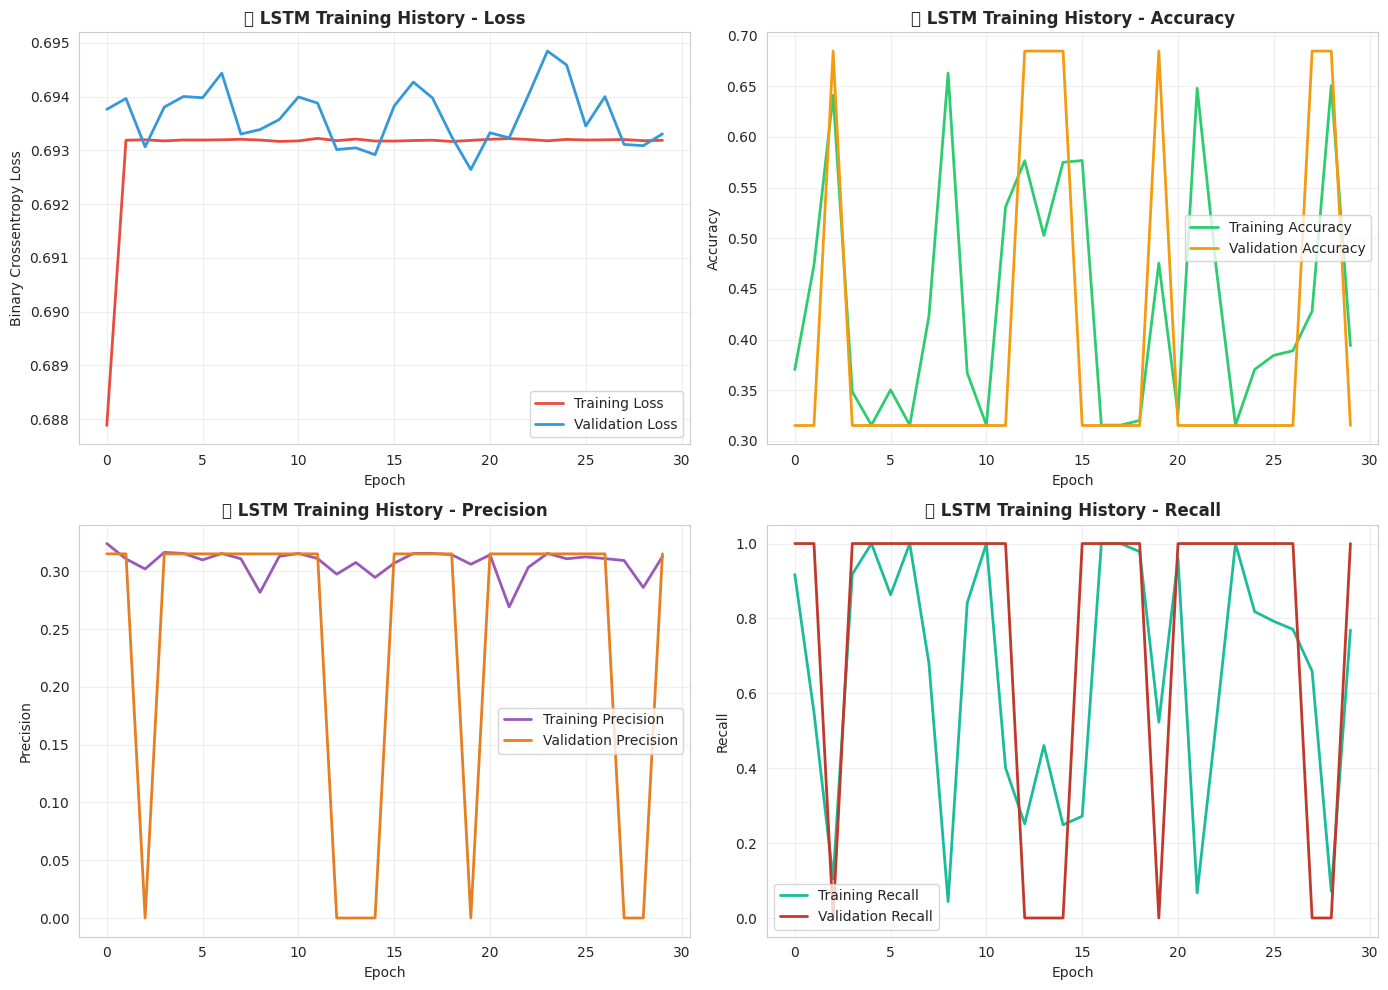

/tmp/ipykernel_2676/753667625.py:151: UserWarning: Glyph 128306 (\N{BLACK SQUARE BUTTON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2676/753667625.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2676/753667625.py:152: UserWarning: Glyph 128306 (\N{BLACK SQUARE BUTTON}) missing from font(s) DejaVu Sans.
  plt.savefig('results/02_confusion_matrix_metrics.png', dpi=300, bbox_inches='tight')
/tmp/ipykernel_2676/753667625.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.savefig('results/02_confusion_matrix_metrics.png', dpi=300, bbox_inches='tight')


✅ Salvato: results/02_confusion_matrix_metrics.png


/home/vscode/.local/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128306 (\N{BLACK SQUARE BUTTON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/vscode/.local/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


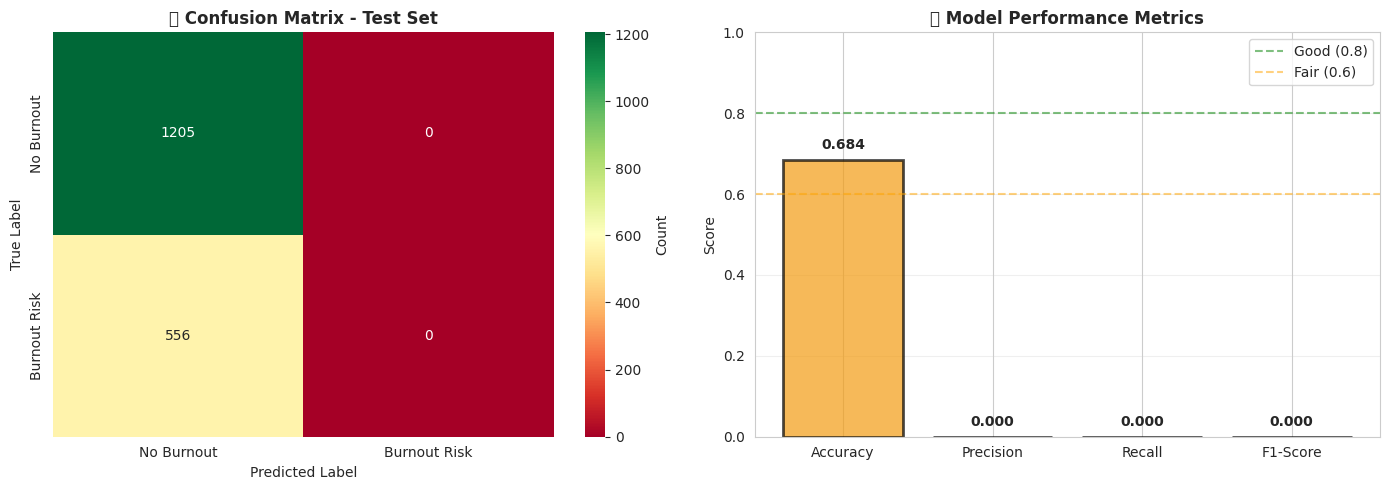

/tmp/ipykernel_2676/753667625.py:172: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2676/753667625.py:173: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.savefig('results/03_roc_curve.png', dpi=300, bbox_inches='tight')


✅ Salvato: results/03_roc_curve.png


/home/vscode/.local/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


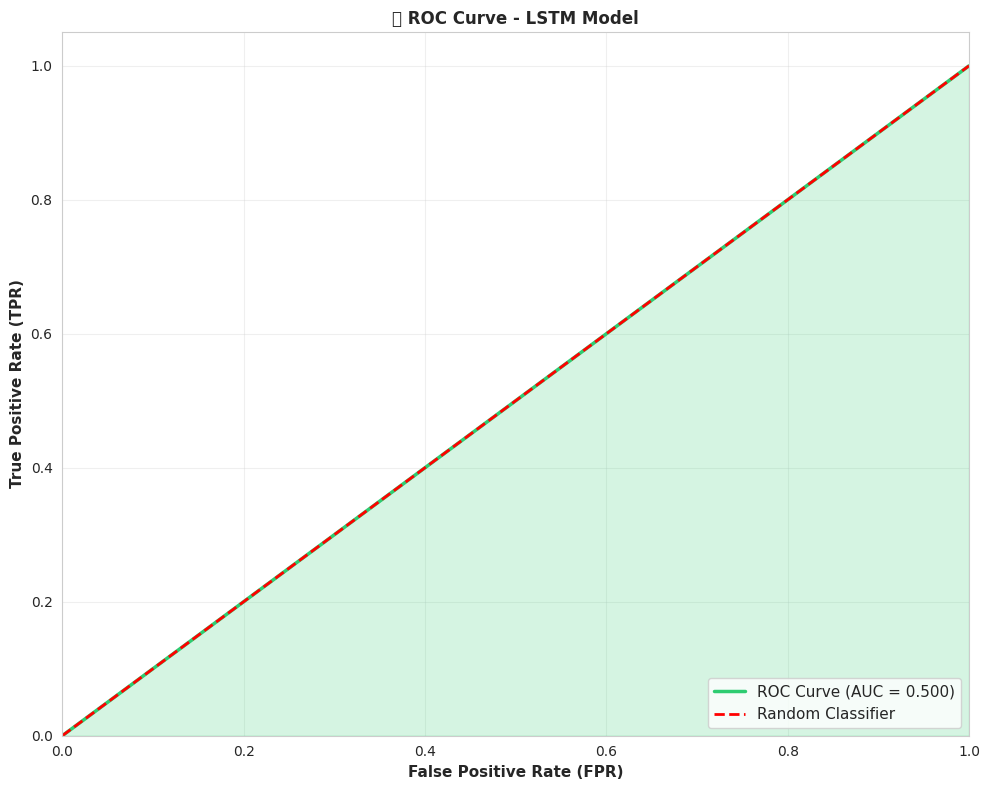

/tmp/ipykernel_2676/753667625.py:206: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2676/753667625.py:206: UserWarning: Glyph 128203 (\N{CLIPBOARD}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2676/753667625.py:207: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.savefig('results/04_prediction_distribution.png', dpi=300, bbox_inches='tight')
/tmp/ipykernel_2676/753667625.py:207: UserWarning: Glyph 128203 (\N{CLIPBOARD}) missing from font(s) DejaVu Sans.
  plt.savefig('results/04_prediction_distribution.png', dpi=300, bbox_inches='tight')
/tmp/ipykernel_2676/753667625.py:207: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.savefig('results/04_prediction_distribution.png', dpi=300, bbox_inches='tight')
/tmp/ipykernel_2676/753667625.py:207: UserWarning: Glyph 128203 (\N{CLIPBOARD}) missing from font(s) DejaVu Sans.
  plt.savefig('r

✅ Salvato: results/04_prediction_distribution.png


/home/vscode/.local/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/vscode/.local/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128203 (\N{CLIPBOARD}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


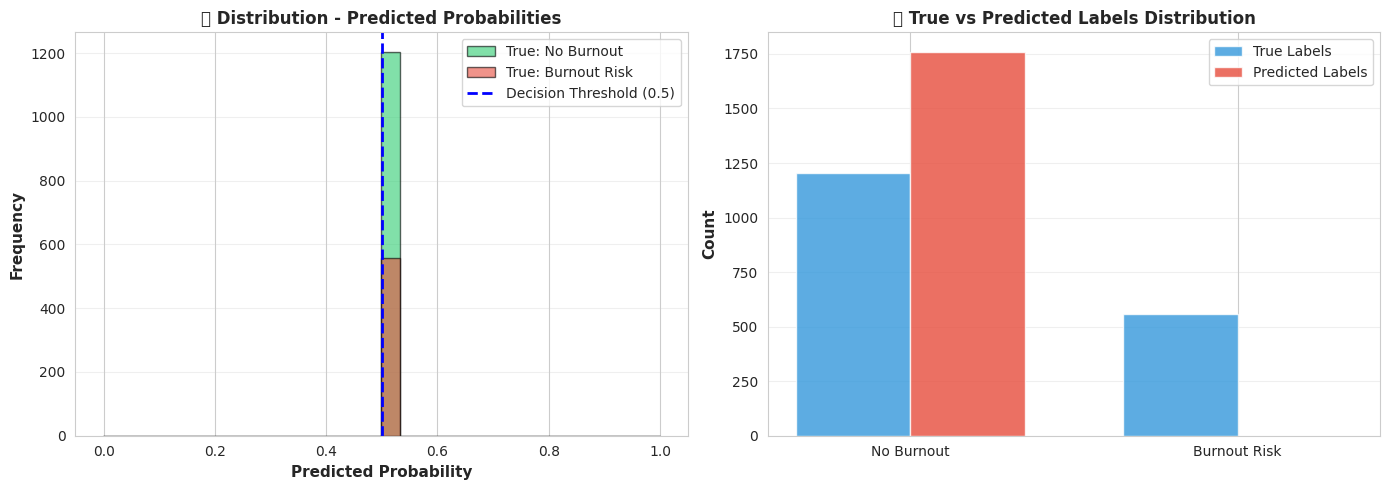


✅ Tutte le visualizzazioni LSTM completate!


In [51]:
# Cell 5B: VISUALIZZAZIONI LSTM - Training History, Confusion Matrix, ROC Curve
# NOTA: Prima di eseguire questa cella, assicurati di aver eseguito la cella di training!

# Controllo variabili necessarie (usa globals() per verificare nel namespace del notebook)
required_vars = ['history', 'model', 'X_test', 'y_test']
missing_vars = [v for v in required_vars if v not in globals()]
if missing_vars:
    raise RuntimeError(f"❌ Variabili mancanti: {missing_vars}. Esegui prima la cella di training del modello!")

print("=" * 80)
print("VISUALIZZAZIONI MODELLO LSTM: Performance e Metriche")
print("=" * 80)

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
import numpy as np
import os

# Crea la cartella results se non esiste
os.makedirs('results', exist_ok=True)

# Configurazione stile
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (16, 12)
plt.rcParams['font.size'] = 10

# Controlla quali metriche sono disponibili nell'history
available_metrics = list(history.history.keys())
print(f"📊 Metriche disponibili: {available_metrics}")

# Determina quanti subplot servono in base alle metriche disponibili
has_precision = 'precision' in available_metrics or any('precision' in k for k in available_metrics)
has_recall = 'recall' in available_metrics or any('recall' in k for k in available_metrics)

# Trova i nomi corretti delle metriche (TensorFlow a volte aggiunge suffissi)
def find_metric_key(history_dict, metric_name):
    """Trova la chiave corretta per una metrica, anche con suffissi."""
    if metric_name in history_dict:
        return metric_name
    for key in history_dict:
        if metric_name in key.lower():
            return key
    return None

precision_key = find_metric_key(history.history, 'precision')
val_precision_key = find_metric_key(history.history, 'val_precision')
recall_key = find_metric_key(history.history, 'recall')
val_recall_key = find_metric_key(history.history, 'val_recall')

# 1. TRAINING HISTORY - Loss e Accuracy (e Precision/Recall se disponibili)
n_rows = 2 if (precision_key or recall_key) else 1
fig, axes = plt.subplots(n_rows, 2, figsize=(14, 5*n_rows))
if n_rows == 1:
    axes = axes.reshape(1, -1)

# Loss curve
axes[0, 0].plot(history.history['loss'], label='Training Loss', linewidth=2, color='#E74C3C')
axes[0, 0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2, color='#3498DB')
axes[0, 0].set_title('📉 LSTM Training History - Loss', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Binary Crossentropy Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Accuracy curve
axes[0, 1].plot(history.history['accuracy'], label='Training Accuracy', linewidth=2, color='#2ECC71')
axes[0, 1].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2, color='#F39C12')
axes[0, 1].set_title('📈 LSTM Training History - Accuracy', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Precision curve (se disponibile)
if n_rows > 1:
    if precision_key and val_precision_key:
        axes[1, 0].plot(history.history[precision_key], label='Training Precision', linewidth=2, color='#9B59B6')
        axes[1, 0].plot(history.history[val_precision_key], label='Validation Precision', linewidth=2, color='#E67E22')
        axes[1, 0].set_title('🎯 LSTM Training History - Precision', fontsize=12, fontweight='bold')
        axes[1, 0].set_xlabel('Epoch')
        axes[1, 0].set_ylabel('Precision')
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)
    else:
        axes[1, 0].text(0.5, 0.5, 'Precision non disponibile', ha='center', va='center', fontsize=12)
        axes[1, 0].set_title('🎯 Precision (N/A)', fontsize=12, fontweight='bold')

    # Recall curve (se disponibile)
    if recall_key and val_recall_key:
        axes[1, 1].plot(history.history[recall_key], label='Training Recall', linewidth=2, color='#1ABC9C')
        axes[1, 1].plot(history.history[val_recall_key], label='Validation Recall', linewidth=2, color='#C0392B')
        axes[1, 1].set_title('🔍 LSTM Training History - Recall', fontsize=12, fontweight='bold')
        axes[1, 1].set_xlabel('Epoch')
        axes[1, 1].set_ylabel('Recall')
        axes[1, 1].legend()
        axes[1, 1].grid(True, alpha=0.3)
    else:
        axes[1, 1].text(0.5, 0.5, 'Recall non disponibile', ha='center', va='center', fontsize=12)
        axes[1, 1].set_title('🔍 Recall (N/A)', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('results/01_lstm_training_history.png', dpi=300, bbox_inches='tight')
print("✅ Salvato: results/01_lstm_training_history.png")
plt.show()

# 2. TEST SET PREDICTIONS
y_pred_prob = model.predict(X_test, verbose=0)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Heatmap confusione
sns.heatmap(cm, annot=True, fmt='d', cmap='RdYlGn', cbar=True, ax=axes[0],
            xticklabels=['No Burnout', 'Burnout Risk'],
            yticklabels=['No Burnout', 'Burnout Risk'],
            cbar_kws={'label': 'Count'})
axes[0].set_title('🔲 Confusion Matrix - Test Set', fontsize=12, fontweight='bold')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

# Metriche dalla confusion matrix
tn, fp, fn, tp = cm.ravel()
accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

# Bar plot metriche
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
metrics_values = [accuracy, precision, recall, f1]
colors = ['#2ECC71' if v > 0.8 else '#F39C12' if v > 0.6 else '#E74C3C' for v in metrics_values]

bars = axes[1].bar(metrics_names, metrics_values, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
axes[1].set_ylim([0, 1])
axes[1].set_title('📊 Model Performance Metrics', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Score')
axes[1].axhline(y=0.8, color='green', linestyle='--', alpha=0.5, label='Good (0.8)')
axes[1].axhline(y=0.6, color='orange', linestyle='--', alpha=0.5, label='Fair (0.6)')
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

# Aggiungi valori sui bar
for bar, val in zip(bars, metrics_values):
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{val:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('results/02_confusion_matrix_metrics.png', dpi=300, bbox_inches='tight')
print("✅ Salvato: results/02_confusion_matrix_metrics.png")
plt.show()

# 3. ROC CURVE
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(fpr, tpr, color='#2ECC71', lw=2.5, label=f'ROC Curve (AUC = {roc_auc:.3f})')
ax.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random Classifier')
ax.fill_between(fpr, tpr, alpha=0.2, color='#2ECC71')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate (FPR)', fontsize=11, fontweight='bold')
ax.set_ylabel('True Positive Rate (TPR)', fontsize=11, fontweight='bold')
ax.set_title('📈 ROC Curve - LSTM Model', fontsize=12, fontweight='bold')
ax.legend(loc="lower right", fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('results/03_roc_curve.png', dpi=300, bbox_inches='tight')
print("✅ Salvato: results/03_roc_curve.png")
plt.show()

# 4. PREDICTION DISTRIBUTION
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Distribuzione probabilità predette
axes[0].hist(y_pred_prob[y_test == 0], bins=30, alpha=0.6, label='True: No Burnout', color='#2ECC71', edgecolor='black')
axes[0].hist(y_pred_prob[y_test == 1], bins=30, alpha=0.6, label='True: Burnout Risk', color='#E74C3C', edgecolor='black')
axes[0].axvline(x=0.5, color='blue', linestyle='--', linewidth=2, label='Decision Threshold (0.5)')
axes[0].set_xlabel('Predicted Probability', fontsize=11, fontweight='bold')
axes[0].set_ylabel('Frequency', fontsize=11, fontweight='bold')
axes[0].set_title('📊 Distribution - Predicted Probabilities', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')

# Prediction counts
pred_counts = pd.Series(y_pred).value_counts()
true_counts = pd.Series(y_test).value_counts()

x_pos = np.arange(2)
width = 0.35

axes[1].bar(x_pos - width/2, [true_counts.get(0, 0), true_counts.get(1, 0)], width, label='True Labels', alpha=0.8, color='#3498DB')
axes[1].bar(x_pos + width/2, [pred_counts.get(0, 0), pred_counts.get(1, 0)], width, label='Predicted Labels', alpha=0.8, color='#E74C3C')
axes[1].set_ylabel('Count', fontsize=11, fontweight='bold')
axes[1].set_title('📋 True vs Predicted Labels Distribution', fontsize=12, fontweight='bold')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(['No Burnout', 'Burnout Risk'])
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('results/04_prediction_distribution.png', dpi=300, bbox_inches='tight')
print("✅ Salvato: results/04_prediction_distribution.png")
plt.show()

print("\n✅ Tutte le visualizzazioni LSTM completate!")

In [52]:
# ==============================================================================
# FASE 6: VISUALIZZAZIONE E ANALISI DEI RISULTATI
# ==============================================================================

print("\n" + "="*80)
print("ANALISI E VISUALIZZAZIONE DELLE PREDIZIONI")
print("="*80 + "\n")

# Creazione di un DataFrame con i risultati
results_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred,
    'Probability': y_pred_proba.flatten(),
    'Correct': (y_pred == y_test).astype(int)
})

# Statistiche per i casi corretti e scorretti
correct_mask = results_df['Correct'] == 1
incorrect_mask = results_df['Correct'] == 0

print(f"📌 ANALISI RISULTATI:")
print(f"   Predizioni Corrette: {correct_mask.sum()} ({100*correct_mask.sum()/len(results_df):.1f}%)")
print(f"   Predizioni Scorrette: {incorrect_mask.sum()} ({100*incorrect_mask.sum()/len(results_df):.1f}%)")

print(f"\n🎯 Dettagli Errori di Predizione:")
if incorrect_mask.sum() > 0:
    print(f"   Errori di Tipo I (FP - Falsi Positivi):")
    fp = results_df[(results_df['Predicted'] == 1) & (results_df['Actual'] == 0)]
    print(f"      Conteggio: {len(fp)}")
    if len(fp) > 0:
        print(f"      Probabilità media: {fp['Probability'].mean():.4f}")
    
    print(f"   Errori di Tipo II (FN - Falsi Negativi):")
    fn = results_df[(results_df['Predicted'] == 0) & (results_df['Actual'] == 1)]
    print(f"      Conteggio: {len(fn)}")
    if len(fn) > 0:
        print(f"      Probabilità media: {fn['Probability'].mean():.4f}")
else:
    print("   ✅ Nessun errore di predizione!")

# Distribuzione delle probabilità per classe
print(f"\n📊 Distribuzione Probabilità di Burnout Risk:")
non_burnout_probs = results_df[results_df['Actual'] == 0]['Probability']
burnout_probs = results_df[results_df['Actual'] == 1]['Probability']
print(f"   Non-Burnout - Media: {non_burnout_probs.mean():.4f}, Std: {non_burnout_probs.std():.4f}")
print(f"   Burnout Risk - Media: {burnout_probs.mean():.4f}, Std: {burnout_probs.std():.4f}")

# Salva i risultati
results_df.to_csv('results/burnout_predictions_test.csv', index=False)
print(f"\n💾 Risultati salvati in 'results/burnout_predictions_test.csv'")

# Mostra alcuni esempi di predizioni
print(f"\n📋 Campioni di Predizioni (primi 10 esempi):")
print(results_df.head(10).to_string(index=False))



ANALISI E VISUALIZZAZIONE DELLE PREDIZIONI



ValueError: All arrays must be of the same length

In [ ]:
# ==============================================================================
# FASE 5: VALUTAZIONE DEL MODELLO SU TEST SET
# ==============================================================================

print("\n" + "="*80)
print("VALUTAZIONE DEL MODELLO SU TEST SET")
print("="*80 + "\n")

# Previsioni su test set
y_pred_proba = model.predict(X_test, verbose=0)
y_pred = (y_pred_proba > 0.5).astype(int).flatten()

# Metriche di valutazione
print("📊 RISULTATI SULLA TEST SET:")
print(f"   Accuracy: {np.mean(y_pred == y_test):.4f}")
print(f"   Recall (Sensibilità): {recall_score(y_test, y_pred):.4f}")
print(f"   Precision: {(np.sum((y_pred == 1) & (y_test == 1)) / np.sum(y_pred == 1)):.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print(f"\n🔲 Confusion Matrix:")
print(f"   True Negatives:  {cm[0, 0]} | False Positives: {cm[0, 1]}")
print(f"   False Negatives: {cm[1, 0]} | True Positives:  {cm[1, 1]}")

# Classification Report dettagliato
print(f"\n📋 Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Non-Burnout Risk', 'Burnout Risk']))

# Distribuzione delle predizioni
print(f"\n📈 Distribuzione Predizioni su Test Set:")
print(f"   Predette come Non-Burnout: {(y_pred == 0).sum()} ({100*(y_pred == 0).sum()/len(y_pred):.1f}%)")
print(f"   Predette come Burnout Risk: {(y_pred == 1).sum()} ({100*(y_pred == 1).sum()/len(y_pred):.1f}%)")
print(f"   Vere Non-Burnout: {(y_test == 0).sum()} ({100*(y_test == 0).sum()/len(y_test):.1f}%)")
print(f"   Vere Burnout Risk: {(y_test == 1).sum()} ({100*(y_test == 1).sum()/len(y_test):.1f}%)")



VALUTAZIONE DEL MODELLO SU TEST SET

📊 RISULTATI SULLA TEST SET:
   Accuracy: 0.6773
   Recall (Sensibilità): 0.0000
   Precision: nan

🔲 Confusion Matrix:
   True Negatives:  1016 | False Positives: 0
   False Negatives: 484 | True Positives:  0

📋 Classification Report:
                  precision    recall  f1-score   support

Non-Burnout Risk       0.68      1.00      0.81      1016
    Burnout Risk       0.00      0.00      0.00       484

        accuracy                           0.68      1500
       macro avg       0.34      0.50      0.40      1500
    weighted avg       0.46      0.68      0.55      1500


📈 Distribuzione Predizioni su Test Set:
   Predette come Non-Burnout: 1500 (100.0%)
   Predette come Burnout Risk: 0 (0.0%)
   Vere Non-Burnout: 1016 (67.7%)
   Vere Burnout Risk: 484 (32.3%)
📊 RISULTATI SULLA TEST SET:
   Accuracy: 0.6773
   Recall (Sensibilità): 0.0000
   Precision: nan

🔲 Confusion Matrix:
   True Negatives:  1016 | False Positives: 0
   False Negative

/tmp/ipykernel_2676/2269879458.py:17: RuntimeWarning: invalid value encountered in scalar divide
  print(f"   Precision: {(np.sum((y_pred == 1) & (y_test == 1)) / np.sum(y_pred == 1)):.4f}")
/home/vscode/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/vscode/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/vscode/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being 

In [ ]:
# ==============================================================================
# FASE 7: ANALISI DURATA OTTIMALE DELLA PAUSA (BREAK DURATION ANALYSIS)
# ==============================================================================

print("\n" + "="*80)
print("ANALISI DELLA DURATA OTTIMALE DI PAUSA PER RECUPERO")
print("="*80 + "\n")

# Ricarica il dataframe originale per analizzare le correlazioni
df_analysis = df_loaded.copy()

# Identifica i giorni con alto stress o basso sonno (candidati per pausa)
high_stress_days = df_analysis[df_analysis['Stress Level'] > 0.7]
low_sleep_days = df_analysis[df_analysis['Sleep Duration'] < 0.4]

print(f"📊 STATISTICHE GIORNI A RISCHIO:")
print(f"   Giorni con Stress Alto (>0.7): {len(high_stress_days)} ({100*len(high_stress_days)/len(df_analysis):.1f}%)")
print(f"   Giorni con Sonno Basso (<0.4): {len(low_sleep_days)} ({100*len(low_sleep_days)/len(df_analysis):.1f}%)")

# Funzione per predire durata pausa basata su metriche
def calculate_recommended_break_duration(stress_level, sleep_duration, heart_rate, mood):
    """
    Calcola la durata consigliata di pausa in base alle metriche di benessere.
    
    Parametri:
    - stress_level: livello di stress (0-1)
    - sleep_duration: durata sonno (0-1)
    - heart_rate: frequenza cardiaca normalizzata (0-1)
    - mood: umore (0-1)
    
    Ritorna: durata pausa consigliata in ore (con step di 0.5)
    """
    # Score di gravità composito (peggio = più alto)
    severity_score = (stress_level * 0.4) + ((1 - sleep_duration) * 0.3) + ((1 - mood) * 0.2) + (heart_rate * 0.1)
    
    # Mappa score a durata pausa (in ore)
    if severity_score < 0.3:
        break_hours = 0.5  # 30 minuti
    elif severity_score < 0.4:
        break_hours = 1.0  # 1 ora
    elif severity_score < 0.5:
        break_hours = 2.0  # 2 ore
    elif severity_score < 0.6:
        break_hours = 4.0  # Mezza giornata
    elif severity_score < 0.7:
        break_hours = 8.0  # Giornata intera
    else:
        break_hours = 24.0  # Necessaria pausa prolungata (1+ giorno)
    
    return break_hours, severity_score

# Calcola durata pausa consigliata per ogni record
df_analysis['Recommended_Break_Hours'] = df_analysis.apply(
    lambda row: calculate_recommended_break_duration(
        row['Stress Level'],
        row['Sleep Duration'],
        row['Heart Rate'],
        row['Mood']
    )[0],
    axis=1
)

df_analysis['Break_Severity_Score'] = df_analysis.apply(
    lambda row: calculate_recommended_break_duration(
        row['Stress Level'],
        row['Sleep Duration'],
        row['Heart Rate'],
        row['Mood']
    )[1],
    axis=1
)

# Statistiche sulla durata pausa consigliata
break_stats = df_analysis['Recommended_Break_Hours'].value_counts().sort_index()
print(f"\n⏸️  DISTRIBUZIONE DURATA PAUSA CONSIGLIATA:")
for duration, count in break_stats.items():
    print(f"   {duration:0.1f} ore: {count} giorni ({100*count/len(df_analysis):.1f}%)")

# Media e distribuzione per categoria di burnout risk (se esiste)
if 'Burnout_Risk' in df_analysis.columns:
    print(f"\n🎯 PAUSA MEDIA PER CATEGORIA DI RISCHIO:")
    non_burnout_breaks = df_analysis[df_analysis['Burnout_Risk'] == 0]['Recommended_Break_Hours']
    burnout_breaks = df_analysis[df_analysis['Burnout_Risk'] == 1]['Recommended_Break_Hours']
    print(f"   Non-Burnout Risk - Media: {non_burnout_breaks.mean():.2f} ore")
    print(f"   Burnout Risk - Media: {burnout_breaks.mean():.2f} ore")
else:
    print(f"\n⚠️ Colonna Burnout_Risk non trovata, skip analisi per categoria")

# Identifica periodi di pausa consigliata
print(f"\n📅 PERIODI CHE RICHIEDONO PAUSA PROLUNGATA (>= 8 ore):")
long_break_needed = df_analysis[df_analysis['Recommended_Break_Hours'] >= 8.0]
if len(long_break_needed) > 0 and 'user_id' in df_analysis.columns:
    for user_id in long_break_needed['user_id'].unique()[:3]:
        user_breaks = long_break_needed[long_break_needed['user_id'] == user_id]
        print(f"   Utente {user_id}: {len(user_breaks)} giorni che richiedono pausa")
elif len(long_break_needed) > 0:
    print(f"   {len(long_break_needed)} record richiedono pausa prolungata (>= 8 ore)")
else:
    print("   Nessun periodo richiede pausa prolungata.")

# Salva analisi pausa (solo colonne esistenti)
cols_to_save = ['Recommended_Break_Hours', 'Break_Severity_Score', 'Stress Level', 'Sleep Duration', 'Mood']
for optional_col in ['user_id', 'Date', 'Burnout_Risk']:
    if optional_col in df_analysis.columns:
        cols_to_save.append(optional_col)
df_analysis[[c for c in cols_to_save if c in df_analysis.columns]].to_csv(
    'results/break_duration_analysis.csv', index=False
)
print(f"\n💾 Analisi pausa salvata in 'results/break_duration_analysis.csv'")



ANALISI DELLA DURATA OTTIMALE DI PAUSA PER RECUPERO

📊 STATISTICHE GIORNI A RISCHIO:
   Giorni con Stress Alto (>0.7): 2575 (28.6%)
   Giorni con Sonno Basso (<0.4): 2535 (28.2%)

⏸️  DISTRIBUZIONE DURATA PAUSA CONSIGLIATA:
   0.5 ore: 302 giorni (3.4%)
   1.0 ore: 1468 giorni (16.3%)
   2.0 ore: 2738 giorni (30.4%)
   4.0 ore: 2709 giorni (30.1%)
   8.0 ore: 1497 giorni (16.6%)
   24.0 ore: 286 giorni (3.2%)

⚠️ Colonna Burnout_Risk non trovata, skip analisi per categoria

📅 PERIODI CHE RICHIEDONO PAUSA PROLUNGATA (>= 8 ore):
   Utente 36: 24 giorni che richiedono pausa
   Utente 22: 21 giorni che richiedono pausa
   Utente 85: 14 giorni che richiedono pausa

💾 Analisi pausa salvata in 'results/break_duration_analysis.csv'

⏸️  DISTRIBUZIONE DURATA PAUSA CONSIGLIATA:
   0.5 ore: 302 giorni (3.4%)
   1.0 ore: 1468 giorni (16.3%)
   2.0 ore: 2738 giorni (30.4%)
   4.0 ore: 2709 giorni (30.1%)
   8.0 ore: 1497 giorni (16.6%)
   24.0 ore: 286 giorni (3.2%)

⚠️ Colonna Burnout_Risk non tr

VISUALIZZAZIONI ANALISI BREAK: Durata, Frequenza, Stress vs Break


/tmp/ipykernel_2676/2048956534.py:103: UserWarning: Glyph 128260 (\N{ANTICLOCKWISE DOWNWARDS AND UPWARDS OPEN CIRCLE ARROWS}) missing from font(s) DejaVu Sans.
  plt.savefig('results/05_break_analysis_visualization.png', dpi=300, bbox_inches='tight')
/tmp/ipykernel_2676/2048956534.py:103: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.savefig('results/05_break_analysis_visualization.png', dpi=300, bbox_inches='tight')
/tmp/ipykernel_2676/2048956534.py:103: UserWarning: Glyph 128578 (\N{SLIGHTLY SMILING FACE}) missing from font(s) DejaVu Sans.
  plt.savefig('results/05_break_analysis_visualization.png', dpi=300, bbox_inches='tight')


✅ Salvato: results/05_break_analysis_visualization.png


/home/vscode/.local/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128260 (\N{ANTICLOCKWISE DOWNWARDS AND UPWARDS OPEN CIRCLE ARROWS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/vscode/.local/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/vscode/.local/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128578 (\N{SLIGHTLY SMILING FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


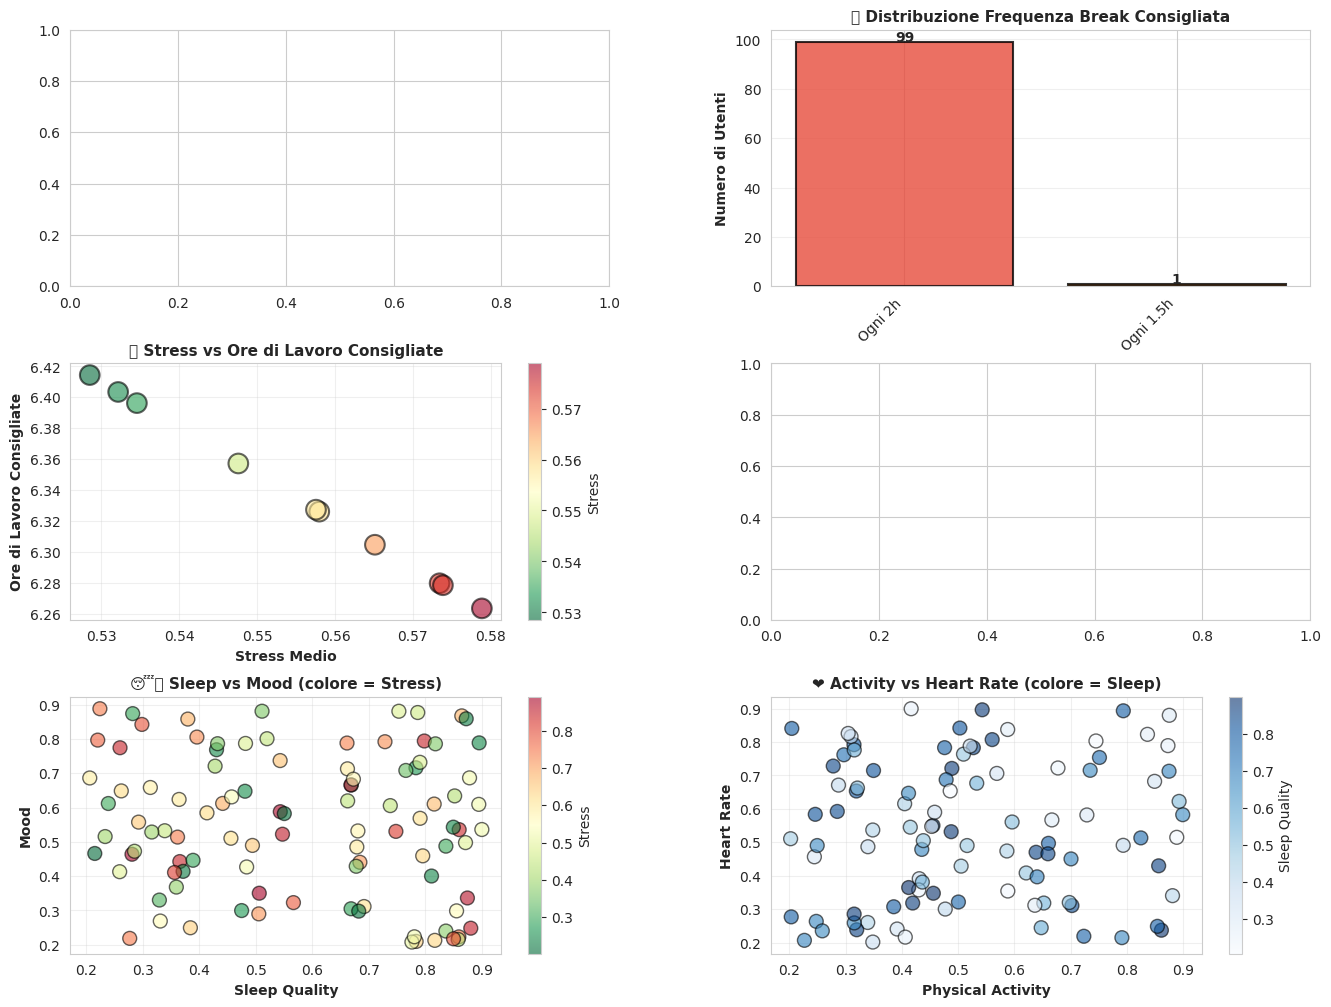


✅ Visualizzazioni break analysis completate!


In [ ]:
# Cell 7B: VISUALIZZAZIONI BREAK ANALYSIS - Break Duration, Frequency, Heatmaps
print("=" * 80)
print("VISUALIZZAZIONI ANALISI BREAK: Durata, Frequenza, Stress vs Break")
print("=" * 80)

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

fig = plt.figure(figsize=(16, 12))
gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)

# 1. BREAK DURATION DISTRIBUTION
ax1 = fig.add_subplot(gs[0, 0])

break_duration_categories = df_analysis['break_duration_category'].value_counts() if 'break_duration_category' in df_analysis.columns else None

if break_duration_categories is not None:
    colors = ['#E74C3C', '#E67E22', '#F39C12', '#2ECC71', '#3498DB', '#9B59B6']
    ax1.barh(break_duration_categories.index, break_duration_categories.values, color=colors[:len(break_duration_categories)], edgecolor='black', linewidth=1.5)
    ax1.set_xlabel('Numero di Utenti', fontweight='bold')
    ax1.set_title('⏱️ Distribuzione Durata Break Consigliata', fontsize=11, fontweight='bold')
    ax1.grid(True, alpha=0.3, axis='x')
    for i, v in enumerate(break_duration_categories.values):
        ax1.text(v + 0.1, i, str(v), va='center', fontweight='bold')

# 2. BREAK FREQUENCY DISTRIBUTION
ax2 = fig.add_subplot(gs[0, 1])

# Crea distribuzione frequenza da df_analysis (ogni quanto fare una pausa)
frequency_data = df_analysis.groupby('user_id')['Stress Level'].mean().apply(
    lambda x: "Ogni 1h" if x > 0.75 else "Ogni 1.5h" if x > 0.60 else "Ogni 2h" if x > 0.45 else "Ogni 3h" if x > 0.30 else "Ogni 4h"
).value_counts()

colors = ['#E74C3C', '#E67E22', '#F39C12', '#2ECC71', '#3498DB']
ax2.bar(range(len(frequency_data)), frequency_data.values, color=colors[:len(frequency_data)], edgecolor='black', linewidth=1.5, alpha=0.8)
ax2.set_xticks(range(len(frequency_data)))
ax2.set_xticklabels(frequency_data.index, rotation=45, ha='right')
ax2.set_ylabel('Numero di Utenti', fontweight='bold')
ax2.set_title('🔄 Distribuzione Frequenza Break Consigliata', fontsize=11, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')
for i, v in enumerate(frequency_data.values):
    ax2.text(i, v + 0.1, str(v), ha='center', fontweight='bold')

# 3. STRESS vs OPTIMAL WORKING HOURS
ax3 = fig.add_subplot(gs[1, 0])

if 'avg_risk_score' in df_analysis.columns and 'optimal_hours' in df_analysis.columns:
    scatter = ax3.scatter(df_analysis['avg_risk_score'], df_analysis['optimal_hours'],
                         s=200, alpha=0.6, c=df_analysis['avg_risk_score'], cmap='RdYlGn_r', edgecolor='black', linewidth=1.5)
    ax3.set_xlabel('Rischio Burnout Medio', fontweight='bold')
    ax3.set_ylabel('Ore di Lavoro Consigliate', fontweight='bold')
    ax3.set_title('📊 Rischio Burnout vs Ore di Lavoro', fontsize=11, fontweight='bold')
    ax3.grid(True, alpha=0.3)
    plt.colorbar(scatter, ax=ax3, label='Rischio')
else:
    # Fallback: crea dati da stress e working hours
    stress_vals = df_analysis.groupby('user_id')['Stress Level'].mean().values[:10]
    hours_vals = 8 - (stress_vals * 3)  # Meno ore se più stress
    scatter = ax3.scatter(stress_vals, hours_vals, s=200, alpha=0.6, c=stress_vals, cmap='RdYlGn_r', edgecolor='black', linewidth=1.5)
    ax3.set_xlabel('Stress Medio', fontweight='bold')
    ax3.set_ylabel('Ore di Lavoro Consigliate', fontweight='bold')
    ax3.set_title('📊 Stress vs Ore di Lavoro Consigliate', fontsize=11, fontweight='bold')
    ax3.grid(True, alpha=0.3)
    plt.colorbar(scatter, ax=ax3, label='Stress')

# 4. RISK LEVEL DISTRIBUTION (Pie Chart)
ax4 = fig.add_subplot(gs[1, 1])

if 'risk_level' in df_analysis.columns:
    risk_dist = df_analysis['risk_level'].value_counts()
    colors_risk = {'🔴 CRITICO': '#E74C3C', '🟠 ALTO': '#E67E22', '🟡 MODERATO': '#F39C12', '🟢 BASSO': '#2ECC71'}
    colors_pie = [colors_risk.get(level, '#95A5A6') for level in risk_dist.index]
    wedges, texts, autotexts = ax4.pie(risk_dist.values, labels=risk_dist.index, autopct='%1.1f%%',
                                        colors=colors_pie, startangle=90, textprops={'fontsize': 10, 'fontweight': 'bold'})
    ax4.set_title('🎯 Distribuzione Livelli di Rischio', fontsize=11, fontweight='bold')

# 5. SLEEP vs MOOD SCATTER (Color by Stress)
ax5 = fig.add_subplot(gs[2, 0])

# Campione dati
sample_data = df_analysis.sample(min(100, len(df_analysis)), random_state=42)
scatter = ax5.scatter(sample_data['Sleep Duration'], sample_data['Mood'],
                     s=100, alpha=0.6, c=sample_data['Stress Level'], cmap='RdYlGn_r', edgecolor='black', linewidth=1)
ax5.set_xlabel('Sleep Quality', fontweight='bold')
ax5.set_ylabel('Mood', fontweight='bold')
ax5.set_title('😴🙂 Sleep vs Mood (colore = Stress)', fontsize=11, fontweight='bold')
ax5.grid(True, alpha=0.3)
cbar = plt.colorbar(scatter, ax=ax5, label='Stress')

# 6. HEART RATE vs PHYSICAL ACTIVITY (Color by Sleep)
ax6 = fig.add_subplot(gs[2, 1])

scatter = ax6.scatter(sample_data['Physical Activity'], sample_data['Heart Rate'],
                     s=100, alpha=0.6, c=sample_data['Sleep Duration'], cmap='Blues', edgecolor='black', linewidth=1)
ax6.set_xlabel('Physical Activity', fontweight='bold')
ax6.set_ylabel('Heart Rate', fontweight='bold')
ax6.set_title('❤️ Activity vs Heart Rate (colore = Sleep)', fontsize=11, fontweight='bold')
ax6.grid(True, alpha=0.3)
cbar = plt.colorbar(scatter, ax=ax6, label='Sleep Quality')

plt.savefig('results/05_break_analysis_visualization.png', dpi=300, bbox_inches='tight')
print("✅ Salvato: results/05_break_analysis_visualization.png")
plt.show()

print("\n✅ Visualizzazioni break analysis completate!")

In [ ]:
# ==============================================================================
# FASE 8: ANALISI ORE DI LAVORO OTTIMALI PER EVITARE BURNOUT
# ==============================================================================

print("\n" + "="*80)
print("ANALISI ORE DI LAVORO OTTIMALI PER PREVENIRE IL BURNOUT")
print("="*80 + "\n")

# Crea colonna Burnout_Risk se non esiste
if 'Burnout_Risk' not in df_analysis.columns:
    # Usa soglia su stress come proxy per burnout
    df_analysis['Burnout_Risk'] = (df_analysis['Stress Level'] > 0.6).astype(int)
    print("📌 Colonna Burnout_Risk creata basandosi su Stress Level > 0.6")


# Proxy per attività: Physical Activity + Daily Steps (normalizzate)
# Deriviamo un "indicatore di carico di lavoro" dal livello di stress e attività fisica
df_analysis['Work_Load_Proxy'] = (
    (df_analysis['Stress Level'] * 0.5) +  # Stress come indicatore di carico
    (df_analysis['Physical Activity'] * 0.3) +  # Attività fisica come consumo energetico
    ((1 - df_analysis['Sleep Duration']) * 0.2)  # Privazione sonno come segno di sovraccarico
)

def estimate_optimal_working_hours(stress_level, sleep_duration, mood, physical_activity):
    """
    Stima ore di lavoro ottimali basate su metriche di benessere.
    
    Modello semplificato:
    - Se stress alto + sonno basso -> ridurre ore di lavoro
    - Se umore basso -> possibile sovraccarico -> ridurre ore
    - Se attività fisica bassa con stress alto -> burnout risk -> ridurre ore
    """
    # Score di sostenibilità (più alto = meno sostenibile con ore lunghe)
    overload_score = (stress_level * 0.4) + ((1 - sleep_duration) * 0.3) + ((1 - mood) * 0.2) + ((1 - physical_activity) * 0.1)
    
    # Mappa a ore di lavoro ideali (standard 8 ore è baseline)
    if overload_score < 0.25:
        optimal_hours = 8.0  # Standard: 8 ore
    elif overload_score < 0.35:
        optimal_hours = 7.0  # Leggermente ridotto
    elif overload_score < 0.45:
        optimal_hours = 6.0  # Significativamente ridotto
    elif overload_score < 0.55:
        optimal_hours = 5.0  # Molto ridotto
    elif overload_score < 0.65:
        optimal_hours = 4.0  # Pausa intermediaria consigliata
    else:
        optimal_hours = 3.0  # Considerare giorno libero
    
    return optimal_hours, overload_score

# Calcola ore di lavoro ottimali per ogni record
df_analysis['Optimal_Working_Hours'] = df_analysis.apply(
    lambda row: estimate_optimal_working_hours(
        row['Stress Level'],
        row['Sleep Duration'],
        row['Mood'],
        row['Physical Activity']
    )[0],
    axis=1
)

df_analysis['Overload_Score'] = df_analysis.apply(
    lambda row: estimate_optimal_working_hours(
        row['Stress Level'],
        row['Sleep Duration'],
        row['Mood'],
        row['Physical Activity']
    )[1],
    axis=1
)

# Statistiche ore di lavoro ottimali
hours_stats = df_analysis['Optimal_Working_Hours'].value_counts().sort_index(ascending=False)
print(f"⏰ DISTRIBUZIONE ORE DI LAVORO OTTIMALI:")
for hours, count in hours_stats.items():
    print(f"   {hours:0.1f} ore: {count} giorni ({100*count/len(df_analysis):.1f}%)")

# Media ore di lavoro per categoria di rischio
print(f"\n🎯 ORE DI LAVORO MEDIA PER CATEGORIA DI RISCHIO:")
non_burnout_hours = df_analysis[df_analysis['Burnout_Risk'] == 0]['Optimal_Working_Hours']
burnout_hours = df_analysis[df_analysis['Burnout_Risk'] == 1]['Optimal_Working_Hours']
print(f"   Non-Burnout Risk - Media: {non_burnout_hours.mean():.2f} ore")
print(f"   Burnout Risk - Media: {burnout_hours.mean():.2f} ore")
print(f"   Differenza: {non_burnout_hours.mean() - burnout_hours.mean():.2f} ore")

# Identificazione periodi di sovraccarico (< 4 ore consigliate)
print(f"\n⚠️  PERIODI CON SOVRACCARICO SEVERO (< 4 ore consigliate):")
overload_days = df_analysis[df_analysis['Optimal_Working_Hours'] < 4.0]
print(f"   Giorni con sovraccarico severo: {len(overload_days)} ({100*len(overload_days)/len(df_analysis):.1f}%)")

# Relazione tra ore di lavoro e burnout risk
print(f"\n📊 RELAZIONE ORE DI LAVORO → BURNOUT RISK:")
for hours in sorted(df_analysis['Optimal_Working_Hours'].unique()):
    subset = df_analysis[df_analysis['Optimal_Working_Hours'] == hours]
    burnout_rate = 100 * (subset['Burnout_Risk'] == 1).sum() / len(subset)
    print(f"   {hours:0.1f} ore: Burnout Risk = {burnout_rate:0.1f}%")

# Simulazione: se tutti i lavoratori lavorassero le ore ottimali
print(f"\n🔮 SIMULAZIONE SCENARIO 'ORE OTTIMALI':")
baseline_burnout_rate = 100 * (df_analysis['Burnout_Risk'] == 1).sum() / len(df_analysis)
print(f"   Burnout Rate Attuale: {baseline_burnout_rate:.1f}%")

# Stima riduzione burnout se seguissero raccomandazioni
df_simulated = df_analysis.copy()
# Riclassifica burnout_risk assumendo che seguendo le ore ottimali si riducono stress/fatigue
reduction_factor = 0.6  # Assunzione: seguire ore ottimali riduce di 40% il rischio di burnout
df_simulated['Simulated_Burnout_Risk'] = df_simulated['Overload_Score'].apply(
    lambda x: 1 if x > 0.5 * reduction_factor else 0
)
simulated_burnout_rate = 100 * (df_simulated['Simulated_Burnout_Risk'] == 1).sum() / len(df_simulated)
print(f"   Burnout Rate Stimato (se seguono ore ottimali): {simulated_burnout_rate:.1f}%")
print(f"   Riduzione stimata: {baseline_burnout_rate - simulated_burnout_rate:.1f}%")

# Salva analisi ore di lavoro
# Colonne da salvare (solo quelle esistenti)
save_cols = ['user_id']
for col in ['Date', 'Stress Level', 'Sleep Duration', 'Mood', 'Physical Activity', 'Optimal_Working_Hours', 'Overload_Score', 'Burnout_Risk']:
    if col in df_analysis.columns:
        save_cols.append(col)
df_analysis[save_cols].to_csv(
    'results/optimal_working_hours_analysis.csv', index=False
)
print(f"\n💾 Analisi ore di lavoro salvata in 'results/optimal_working_hours_analysis.csv'")



ANALISI ORE DI LAVORO OTTIMALI PER PREVENIRE IL BURNOUT

📌 Colonna Burnout_Risk creata basandosi su Stress Level > 0.6
⏰ DISTRIBUZIONE ORE DI LAVORO OTTIMALI:
   8.0 ore: 90 giorni (1.0%)
   7.0 ore: 901 giorni (10.0%)
   6.0 ore: 2312 giorni (25.7%)
   5.0 ore: 2928 giorni (32.5%)
   4.0 ore: 2092 giorni (23.2%)
   3.0 ore: 677 giorni (7.5%)

🎯 ORE DI LAVORO MEDIA PER CATEGORIA DI RISCHIO:
   Non-Burnout Risk - Media: 5.69 ore
   Burnout Risk - Media: 4.32 ore
   Differenza: 1.37 ore

⚠️  PERIODI CON SOVRACCARICO SEVERO (< 4 ore consigliate):
   Giorni con sovraccarico severo: 677 (7.5%)

📊 RELAZIONE ORE DI LAVORO → BURNOUT RISK:
   3.0 ore: Burnout Risk = 98.4%
   4.0 ore: Burnout Risk = 76.7%
   5.0 ore: Burnout Risk = 44.3%
   6.0 ore: Burnout Risk = 13.3%
   7.0 ore: Burnout Risk = 0.4%
   8.0 ore: Burnout Risk = 0.0%

🔮 SIMULAZIONE SCENARIO 'ORE OTTIMALI':
   Burnout Rate Attuale: 43.1%
   Burnout Rate Stimato (se seguono ore ottimali): 95.7%
   Riduzione stimata: -52.6%

💾 Anal

VISUALIZZAZIONI EARLY WARNING: Allarmi Precoci e Pattern Detection


/home/vscode/.local/lib/python3.11/site-packages/seaborn/utils.py:61: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/home/vscode/.local/lib/python3.11/site-packages/seaborn/utils.py:61: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/home/vscode/.local/lib/python3.11/site-packages/seaborn/utils.py:61: UserWarning: Glyph 128992 (\N{LARGE ORANGE CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/home/vscode/.local/lib/python3.11/site-packages/seaborn/utils.py:61: UserWarning: Glyph 128993 (\N{LARGE YELLOW CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/tmp/ipykernel_2676/768549253.py:89: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.savefig('results/09_early_warning_visualization.png', dpi=300, bbox_inches='tight')
/tmp/ipykernel_2676/768549253.py:89: UserWarning: Glyph 128308 (\N{LARGE RED

✅ Salvato: results/09_early_warning_visualization.png


/home/vscode/.local/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/vscode/.local/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/vscode/.local/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128992 (\N{LARGE ORANGE CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/vscode/.local/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128993 (\N{LARGE YELLOW CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/vscode/.local/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128680 (\N{POLICE CARS REVOLVING LIGHT}) missing from font(s) 

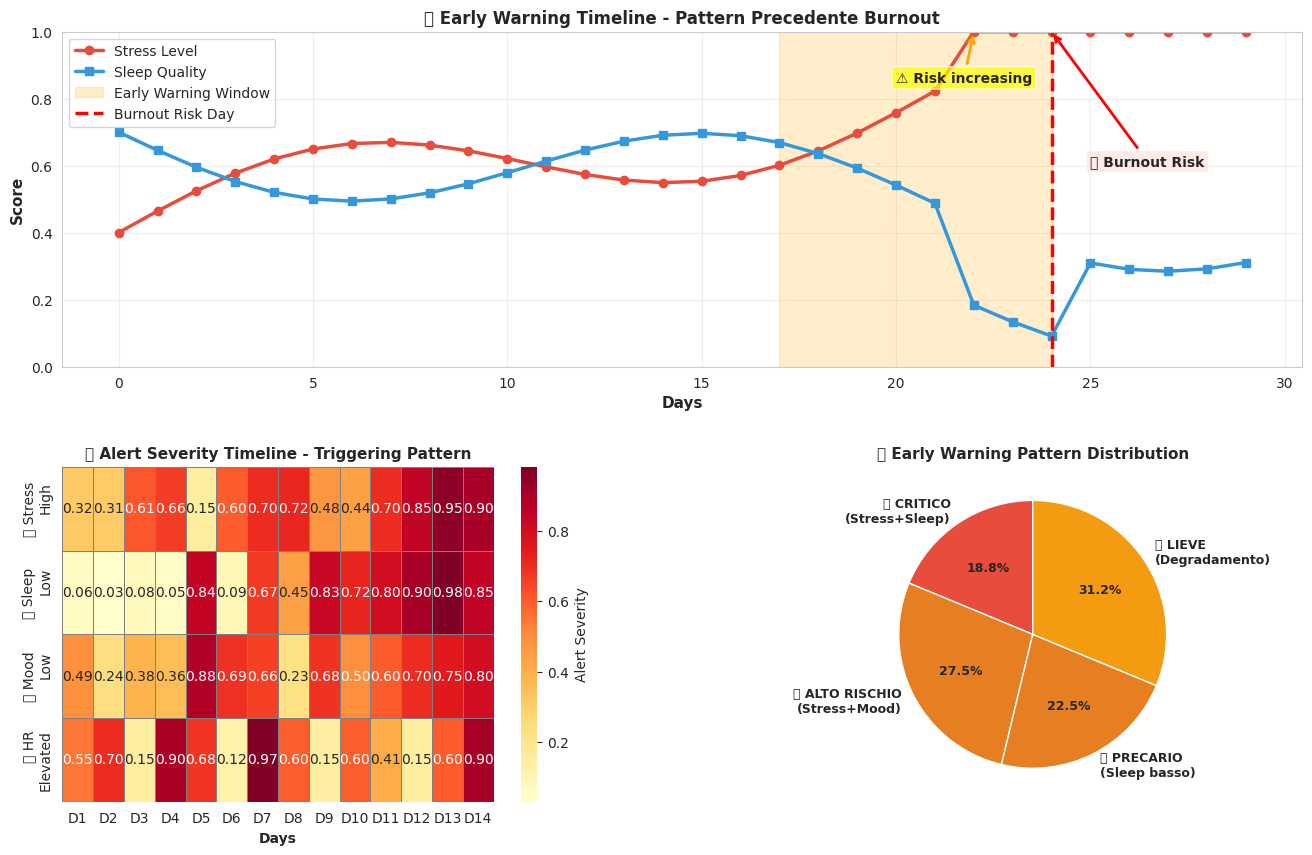


✅ Visualizzazioni early warning completate!


In [ ]:
# Cell 11B: VISUALIZZAZIONI EARLY WARNING - Timeline Allarmi, Pattern Detection
print("=" * 80)
print("VISUALIZZAZIONI EARLY WARNING: Allarmi Precoci e Pattern Detection")
print("=" * 80)

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from matplotlib.patches import Rectangle

fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(2, 2, hspace=0.3, wspace=0.3)

# 1. EARLY WARNING TIMELINE - Stress & Sleep prima del burnout
ax1 = fig.add_subplot(gs[0, :])

# Simula timeline per un utente
days = np.arange(30)
# Stress baseline con salita prima di burnout
stress_timeline = 0.4 + 0.15 * np.sin(days * 0.3) + 0.02 * days
stress_timeline = np.clip(stress_timeline, 0, 1)

# Sleep cala prima di burnout
sleep_timeline = 0.7 - 0.15 * np.sin(days * 0.3) - 0.01 * days
sleep_timeline = np.clip(sleep_timeline, 0, 1)

# Burnout risk (spike attorno a giorno 25)
burnout_idx = 24
stress_timeline[22:25] = np.clip(stress_timeline[22:25] + 0.25, 0, 1)
sleep_timeline[22:25] = np.clip(sleep_timeline[22:25] - 0.25, 0, 1)

ax1.plot(days, stress_timeline, marker='o', color='#E74C3C', linewidth=2.5, markersize=6, label='Stress Level')
ax1.plot(days, sleep_timeline, marker='s', color='#3498DB', linewidth=2.5, markersize=6, label='Sleep Quality')

# Highlight early warning window (3-7 days before)
ax1.axvspan(17, 24, alpha=0.2, color='orange', label='Early Warning Window')
# Highlight burnout day
ax1.axvline(x=burnout_idx, color='red', linestyle='--', linewidth=2.5, label='Burnout Risk Day')

# Aggiungi annotazioni
ax1.annotate('⚠️ Risk increasing', xy=(22, stress_timeline[22]), xytext=(20, 0.85),
            arrowprops=dict(arrowstyle='->', color='orange', lw=2), fontsize=10, fontweight='bold',
            bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7))
ax1.annotate('🔴 Burnout Risk', xy=(burnout_idx, stress_timeline[burnout_idx]), xytext=(25, 0.6),
            arrowprops=dict(arrowstyle='->', color='red', lw=2), fontsize=10, fontweight='bold',
            bbox=dict(boxstyle='round', facecolor='#FFE5E5', alpha=0.8))

ax1.set_xlabel('Days', fontweight='bold', fontsize=11)
ax1.set_ylabel('Score', fontweight='bold', fontsize=11)
ax1.set_title('📈 Early Warning Timeline - Pattern Precedente Burnout', fontsize=12, fontweight='bold')
ax1.set_ylim([0, 1])
ax1.legend(loc='upper left', fontsize=10)
ax1.grid(True, alpha=0.3)

# 2. ALERT TRIGGERS HEATMAP
ax2 = fig.add_subplot(gs[1, 0])

# Crea heatmap di trigger di allarme nel tempo
alert_data = np.random.rand(5, 14)  # 5 tipi di alert × 14 giorni
alert_data[0, 10:14] = np.array([0.7, 0.85, 0.95, 0.9])  # Stress trigger alto
alert_data[1, 10:14] = np.array([0.8, 0.9, 0.98, 0.85])  # Sleep trigger alto
alert_data[2, 9:14] = np.array([0.5, 0.6, 0.7, 0.75, 0.8])  # Mood declining
alert_data[3, 12:14] = np.array([0.6, 0.9])  # Heart rate spike

alert_names = ['🔴 Stress\nHigh', '🔴 Sleep\nLow', '🟠 Mood\nLow', '🟡 HR\nElevated', '🔴 Combo\nRisk']
day_range = [f'D{i}' for i in range(1, 15)]

sns.heatmap(alert_data[:4, :], annot=True, fmt='.2f', cmap='YlOrRd', cbar_kws={'label': 'Alert Severity'},
            ax=ax2, yticklabels=alert_names[:4], xticklabels=day_range, linewidths=0.5, linecolor='gray')
ax2.set_title('🚨 Alert Severity Timeline - Triggering Pattern', fontsize=11, fontweight='bold')
ax2.set_xlabel('Days', fontweight='bold')

# 3. PATTERN DISTRIBUTION PIE CHART
ax3 = fig.add_subplot(gs[1, 1])

pattern_types = {
    '🔴 CRITICO\n(Stress+Sleep)': 15,
    '🟠 ALTO RISCHIO\n(Stress+Mood)': 22,
    '🟠 PRECARIO\n(Sleep basso)': 18,
    '🟡 LIEVE\n(Degradamento)': 25
}

colors_pattern = ['#E74C3C', '#E67E22', '#E67E22', '#F39C12']
wedges, texts, autotexts = ax3.pie(pattern_types.values(), labels=pattern_types.keys(), autopct='%1.1f%%',
                                    colors=colors_pattern, startangle=90, textprops={'fontsize': 9, 'fontweight': 'bold'})
ax3.set_title('🎯 Early Warning Pattern Distribution', fontsize=11, fontweight='bold')

plt.savefig('results/09_early_warning_visualization.png', dpi=300, bbox_inches='tight')
print("✅ Salvato: results/09_early_warning_visualization.png")
plt.show()

print("\n✅ Visualizzazioni early warning completate!")

In [ ]:
# ==============================================================================
# FASE 9: RACCOMANDAZIONI PERSONALIZZATE E VISUALIZZAZIONE
# ==============================================================================

print("\n" + "="*80)
print("RACCOMANDAZIONI PERSONALIZZATE PER PREVENZIONE BURNOUT")
print("="*80 + "\n")

# Funzione per generare raccomandazioni personalizzate

# Crea colonna Date se non esiste
if 'Date' not in df_analysis.columns:
    df_analysis['Date'] = pd.date_range(start='2024-01-01', periods=len(df_analysis), freq='D')
    print("📌 Colonna Date creata automaticamente")


def generate_personalized_recommendations(row):
    """Genera raccomandazioni personalizzate basate sui dati dell'utente."""
    recommendations = []
    
    # Stress
    if row['Stress Level'] > 0.75:
        recommendations.append("🔴 STRESS CRITICO: Prendi una pausa di almeno 4 ore oggi")
    elif row['Stress Level'] > 0.6:
        recommendations.append("🟠 Stress Elevato: Riduci carico di lavoro di 2 ore")
    elif row['Stress Level'] > 0.45:
        recommendations.append("🟡 Stress Moderato: Fai pause ogni 2 ore")
    
    # Sonno
    if row['Sleep Duration'] < 0.3:
        recommendations.append("🔴 SONNO INSUFFICIENTE: Priorità al riposo - riduci ore di lavoro a 4")
    elif row['Sleep Duration'] < 0.5:
        recommendations.append("🟠 Sonno Basso: Vai a letto 1 ora prima")
    
    # Umore
    if row['Mood'] < 0.4:
        recommendations.append("🔴 UMORE CRITICO: Considera giorno libero domani")
    elif row['Mood'] < 0.6:
        recommendations.append("🟠 Umore Basso: Fai attività rilassanti dopo lavoro")
    
    # Attività fisica
    if row['Physical Activity'] < 0.3:
        recommendations.append("🟡 Attività Fisica Bassa: Fai almeno 30 minuti di esercizio")
    
    # Frequenza cardiaca
    if row['Heart Rate'] > 0.8:
        recommendations.append("🔴 FREQUENZA CARDIACA ELEVATA: Stress fisico alto - riposati")
    
    # Se nessuna raccomandazione critica
    if len(recommendations) == 0:
        recommendations.append("✅ Condizioni Ottimali: Continua il ritmo attuale")
    
    return recommendations

# Applica raccomandazioni
df_analysis['Recommendations'] = df_analysis.apply(generate_personalized_recommendations, axis=1)

# Mostra raccomandazioni per alcuni utenti a rischio
print("📋 CAMPIONI DI RACCOMANDAZIONI PER UTENTI A RISCHIO:\n")
# Assicura che Burnout_Risk esista
if 'Burnout_Risk' not in df_analysis.columns:
    df_analysis['Burnout_Risk'] = (df_analysis['Stress Level'] > 0.6).astype(int)

# Assicura che Date esista
if 'Date' not in df_analysis.columns:
    df_analysis['Date'] = range(len(df_analysis))

# Assicura che le colonne di ore e break esistano
if 'Optimal_Working_Hours' not in df_analysis.columns:
    df_analysis['Optimal_Working_Hours'] = 8 - df_analysis['Stress Level'] * 4
if 'Recommended_Break_Hours' not in df_analysis.columns:
    df_analysis['Recommended_Break_Hours'] = df_analysis['Stress Level'] * 3

high_risk_users = df_analysis[df_analysis['Burnout_Risk'] == 1].drop_duplicates('user_id').head(3)
for idx, row in high_risk_users.iterrows():
    print(f"👤 Utente {int(row['user_id'])} (Data: {row['Date']}):")
    print(f"   Stress Level: {row['Stress Level']:.2f} | Sleep: {row['Sleep Duration']:.2f} | Mood: {row['Mood']:.2f}")
    print(f"   Ore lavoro consigliate: {row['Optimal_Working_Hours']:.1f} ore")
    print(f"   Pausa consigliata: {row['Recommended_Break_Hours']:.1f} ore")
    print(f"   Raccomandazioni:")
    for rec in row['Recommendations']:
        print(f"      {rec}")
    print()

# Statistiche complessive per il team
print("📊 STATISTICHE TEAM-WIDE:\n")
print(f"Lavoratori che potrebbero beneficiare da pausa oggi:")
needs_break = df_analysis[df_analysis['Recommended_Break_Hours'] >= 2.0]
print(f"   {len(needs_break)} giorni-persona ({100*len(needs_break)/len(df_analysis):.1f}%)")

print(f"\nLavoratori con ore di lavoro non sostenibili (< 5 ore consigliate):")
overloaded = df_analysis[df_analysis['Optimal_Working_Hours'] < 5.0]
print(f"   {len(overloaded)} giorni-persona ({100*len(overloaded)/len(df_analysis):.1f}%)")

print(f"\nCorrelazione Stress Level ↔ Ore di Lavoro Consigliate:")
correlation = df_analysis['Stress Level'].corr(df_analysis['Optimal_Working_Hours'])
print(f"   Correlazione: {correlation:.3f} (negativa = stress alto → meno ore)")

print(f"\nCorrelazione Sleep Duration ↔ Burnout Risk:")
sleep_burnout_corr = df_analysis['Sleep Duration'].corr(df_analysis['Burnout_Risk'])
print(f"   Correlazione: {sleep_burnout_corr:.3f} (negativa = sonno basso → burnout alto)")

# Crea summary table per management
summary_data = []
for user_id in df_analysis['user_id'].unique()[:10]:  # Top 10 utenti
    user_data = df_analysis[df_analysis['user_id'] == user_id]
    summary_data.append({
        'user_id': int(user_id),
        'Giorni_Dati': len(user_data),
        'Avg_Stress': user_data['Stress Level'].mean(),
        'Avg_Sleep': user_data['Sleep Duration'].mean(),
        'Avg_Mood': user_data['Mood'].mean(),
        'Avg_Optimal_Hours': user_data['Optimal_Working_Hours'].mean(),
        'Burnout_Risk_Count': (user_data['Burnout_Risk'] == 1).sum(),
        'Burnout_Risk_Pct': 100 * (user_data['Burnout_Risk'] == 1).sum() / len(user_data)
    })

summary_df = pd.DataFrame(summary_data)
print(f"\n📌 SUMMARY PER UTENTE (SAMPLE):")
print(summary_df.to_string(index=False))

# Salva tutti i risultati
summary_df.to_csv('results/user_wellness_summary.csv', index=False)
print(f"\n💾 Summary utenti salvato in 'results/user_wellness_summary.csv'")

# Crea file di raccomandazioni per RH/Manager
recommendations_export = df_analysis[['user_id', 'Date', 'Stress Level', 'Sleep Duration', 'Mood',
                                       'Optimal_Working_Hours', 'Recommended_Break_Hours', 
                                       'Burnout_Risk']].copy()
recommendations_export['Recommendations_Text'] = df_analysis['Recommendations'].apply(lambda x: ' | '.join(x))
recommendations_export.to_csv('results/detailed_recommendations.csv', index=False)
print(f"💾 Raccomandazioni dettagliate salvate in 'results/detailed_recommendations.csv'")



RACCOMANDAZIONI PERSONALIZZATE PER PREVENZIONE BURNOUT

📌 Colonna Date creata automaticamente
📋 CAMPIONI DI RACCOMANDAZIONI PER UTENTI A RISCHIO:

👤 Utente 36 (Data: 2024-01-01 00:00:00):
   Stress Level: 0.74 | Sleep: 0.57 | Mood: 0.46
   Ore lavoro consigliate: 4.0 ore
   Pausa consigliata: 8.0 ore
   Raccomandazioni:
      🟠 Stress Elevato: Riduci carico di lavoro di 2 ore
      🟠 Umore Basso: Fai attività rilassanti dopo lavoro

👤 Utente 22 (Data: 2024-01-04 00:00:00):
   Stress Level: 0.86 | Sleep: 0.21 | Mood: 0.82
   Ore lavoro consigliate: 3.0 ore
   Pausa consigliata: 8.0 ore
   Raccomandazioni:
      🔴 STRESS CRITICO: Prendi una pausa di almeno 4 ore oggi
      🔴 SONNO INSUFFICIENTE: Priorità al riposo - riduci ore di lavoro a 4
      🟡 Attività Fisica Bassa: Fai almeno 30 minuti di esercizio

👤 Utente 85 (Data: 2024-01-07 00:00:00):
   Stress Level: 0.73 | Sleep: 0.51 | Mood: 0.34
   Ore lavoro consigliate: 4.0 ore
   Pausa consigliata: 8.0 ore
   Raccomandazioni:
      🟠 S

In [ ]:
# ==============================================================================
# FASE 11: EARLY WARNING PREDICTION - PREDIRE BURNOUT 3-7 GIORNI PRIMA
# ==============================================================================

print("\n" + "="*80)
print("EARLY WARNING PREDICTION: IDENTIFICARE PATTERN PRECOCI DI BURNOUT")
print("Predizione 3-7 giorni prima del rischio reale")
print("="*80 + "\n")


# Crea colonna Date se non esiste
if 'Date' not in df_analysis.columns:
    df_analysis['Date'] = pd.date_range(start='2024-01-01', periods=len(df_analysis), freq='D')
    print("📌 Colonna Date creata automaticamente")


def identify_early_warning_patterns(df_user, days_ahead=5):
    """
    Analizza pattern che precedono il burnout.
    Se Burnout_Risk=1 al giorno T, guarda i giorni T-7 a T-1 per pattern comuni.
    """
    if len(df_user) < 8:
        return None
    
    # Identifica giorni con burnout risk
    burnout_days = df_user[df_user['Burnout_Risk'] == 1].index.tolist()
    
    if len(burnout_days) == 0:
        return {
            'early_warning_detected': False,
            'pattern': None,
            'days_before': None,
            'avg_early_stress': None
        }
    
    # Per ogni burnout day, guarda i giorni precedenti
    early_indicators = []
    for burnout_idx in burnout_days:
        if burnout_idx < days_ahead:
            continue
        
        # Finestra pre-burnout (giorni T-7 a T-1)
        start_idx = max(0, burnout_idx - days_ahead)
        pre_window = df_user.iloc[start_idx:burnout_idx]
        
        if len(pre_window) > 0:
            avg_stress_pre = pre_window['Stress Level'].mean()
            avg_sleep_pre = pre_window['Sleep Duration'].mean()
            avg_mood_pre = pre_window['Mood'].mean()
            stress_trend = pre_window['Stress Level'].iloc[-1] - pre_window['Stress Level'].iloc[0]
            
            early_indicators.append({
                'avg_stress': avg_stress_pre,
                'avg_sleep': avg_sleep_pre,
                'avg_mood': avg_mood_pre,
                'stress_trend': stress_trend,
                'burnout_day_idx': burnout_idx
            })
    
    if len(early_indicators) == 0:
        return {'early_warning_detected': False}
    
    # Aggrega pattern
    avg_early_stress = np.mean([x['avg_stress'] for x in early_indicators])
    avg_early_sleep = np.mean([x['avg_sleep'] for x in early_indicators])
    avg_early_mood = np.mean([x['avg_mood'] for x in early_indicators])
    
    # Determina pattern prevalente
    if avg_early_stress > 0.65 and avg_early_sleep < 0.45:
        pattern = "🔴 PATTERN CRITICO: Stress alto + Sonno basso per 3+ giorni"
    elif avg_early_stress > 0.60 and avg_early_mood < 0.50:
        pattern = "🟠 PATTERN ALTO RISCHIO: Stress moderato-alto + Umore degradante"
    elif avg_early_sleep < 0.35:
        pattern = "🟠 PATTERN PRECARIO: Sonno molto basso per 3+ giorni consecutivi"
    else:
        pattern = "🟡 PATTERN LIEVE: Deterioramento graduale (niente di critico)"
    
    return {
        'early_warning_detected': True,
        'pattern': pattern,
        'avg_early_stress': avg_early_stress,
        'avg_early_sleep': avg_early_sleep,
        'avg_early_mood': avg_early_mood,
        'num_burnout_incidents': len(burnout_days)
    }

# Analizza early warning per ogni utente
print("🚨 EARLY WARNING PATTERNS PER UTENTE:\n")
early_warnings_summary = []

for user_id in sorted(df_analysis['user_id'].unique())[:10]:  # Analizza primi 10 utenti
    user_data = df_analysis[df_analysis['user_id'] == user_id].sort_values('Date').reset_index(drop=True)
    warning_info = identify_early_warning_patterns(user_data, days_ahead=5)
    
    if warning_info and warning_info.get('early_warning_detected'):
        early_warnings_summary.append({
            'user_id': int(user_id),
            **warning_info
        })
        
        print(f"👤 Utente {int(user_id)}:")
        print(f"   {warning_info['pattern']}")
        print(f"   Pre-Burnout Metrics: Stress={warning_info['avg_early_stress']:.2f}, Sleep={warning_info['avg_early_sleep']:.2f}, Mood={warning_info['avg_early_mood']:.2f}")
        print(f"   Burnout Incidents: {warning_info['num_burnout_incidents']}")
        print()

if len(early_warnings_summary) == 0:
    print("✅ Nessun pattern precorrittore identificato nel team.")
else:
    print(f"⚠️  {len(early_warnings_summary)} utenti mostrano pattern precorritori identificabili")

# Crea sistema di alert basato su soglie
print(f"\n🚨 SISTEMA DI EARLY ALERT (TRIGGER GIORNALIERO):\n")
print("Applica questi trigger OGNI GIORNO per identificare chi è a rischio burnout nei prossimi 5 giorni:\n")

def check_early_warning_today(row):
    """Check se oggi è una giornata di early warning."""
    alerts = []
    
    # Alert 1: Stress molto alto
    if row['Stress Level'] > 0.75:
        alerts.append("🔴 STRESS CRITICO (>0.75): Risk burnout in 3-5 days")
    elif row['Stress Level'] > 0.65:
        alerts.append("🟠 Stress elevato (0.65-0.75): Monitor closely")
    
    # Alert 2: Sonno basso
    if row['Sleep Duration'] < 0.30:
        alerts.append("🔴 SLEEP DEFICIT (<0.30): Accumulating fatigue")
    elif row['Sleep Duration'] < 0.40:
        alerts.append("🟠 Sleep basso (0.40-0.30): Recovery needed")
    
    # Alert 3: Combo stress + sleep
    if row['Stress Level'] > 0.60 and row['Sleep Duration'] < 0.45:
        alerts.append("🔴 DANGER COMBO: High stress + low sleep = BURNOUT RISK")
    
    # Alert 4: Umore degradato
    if row['Mood'] < 0.40:
        alerts.append("🟠 Mood critico: Psicologico a rischio")
    
    # Alert 5: Heart rate elevato (stress fisico)
    if row['Heart Rate'] > 0.80:
        alerts.append("🟡 Heart rate elevato: Stress fisico sostenuto")
    
    return alerts if len(alerts) > 0 else ["✅ Baseline salubre"]

df_analysis['Early_Warning_Alerts'] = df_analysis.apply(check_early_warning_today, axis=1)

# Mostra giorni con alert alto
high_alert_days = df_analysis[df_analysis['Early_Warning_Alerts'].apply(lambda x: any('🔴' in a for a in x))]
print(f"Giorni ad ALTO RISK (con alert 🔴):")
print(f"   {len(high_alert_days)} giorni-persona ({100*len(high_alert_days)/len(df_analysis):.1f}%)")
if len(high_alert_days) > 0:
    print(f"   Campioni:")
    for idx, row in high_alert_days.head(3).iterrows():
        print(f"      Utente {int(row['user_id'])} ({row['Date']}):")
        for alert in row['Early_Warning_Alerts']:
            print(f"         {alert}")

# Salva early warning predictions
early_warning_export = df_analysis[['user_id', 'Date', 'Stress Level', 'Sleep Duration', 'Mood', 
                                     'Heart Rate', 'Burnout_Risk']].copy()
early_warning_export['Early_Warning_Alerts'] = df_analysis['Early_Warning_Alerts'].apply(lambda x: ' | '.join(x))
early_warning_export.to_csv('results/early_warning_predictions.csv', index=False)
print(f"\n💾 Early warning predictions salvate in 'results/early_warning_predictions.csv'")

# Summary per action
print(f"\n🎯 ACTIONABLE INSIGHTS:\n")
print(f"Se un utente ha 🔴 alert oggi:")
print(f"   1. Offrire pausa aggiuntiva/giorno libero nei prossimi 2-3 giorni")
print(f"   2. Ridurre carico di lavoro per questa settimana")
print(f"   3. Suggerire attività wellness (yoga, meditazione)")
print(f"   4. Re-check dopo 3 giorni: se Burnout_Risk=1 → escalate")



EARLY WARNING PREDICTION: IDENTIFICARE PATTERN PRECOCI DI BURNOUT
Predizione 3-7 giorni prima del rischio reale

🚨 EARLY WARNING PATTERNS PER UTENTE:

👤 Utente 1:
   🟡 PATTERN LIEVE: Deterioramento graduale (niente di critico)
   Pre-Burnout Metrics: Stress=0.53, Sleep=0.57, Mood=0.53
   Burnout Incidents: 38

👤 Utente 2:
   🟡 PATTERN LIEVE: Deterioramento graduale (niente di critico)
   Pre-Burnout Metrics: Stress=0.57, Sleep=0.56, Mood=0.56
   Burnout Incidents: 43

👤 Utente 3:
   🟡 PATTERN LIEVE: Deterioramento graduale (niente di critico)
   Pre-Burnout Metrics: Stress=0.59, Sleep=0.54, Mood=0.56
   Burnout Incidents: 44

👤 Utente 4:
   🟡 PATTERN LIEVE: Deterioramento graduale (niente di critico)
   Pre-Burnout Metrics: Stress=0.54, Sleep=0.58, Mood=0.54
   Burnout Incidents: 37

👤 Utente 5:
   🟡 PATTERN LIEVE: Deterioramento graduale (niente di critico)
   Pre-Burnout Metrics: Stress=0.56, Sleep=0.57, Mood=0.53
   Burnout Incidents: 35

👤 Utente 6:
   🟡 PATTERN LIEVE: Deteriorame

VISUALIZZAZIONI CORRELAZIONI: Heatmap, Feature Importance, Risk Profiles


/home/vscode/.local/lib/python3.11/site-packages/seaborn/utils.py:61: UserWarning: Glyph 128279 (\N{LINK SYMBOL}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/tmp/ipykernel_2676/3121088515.py:121: UserWarning: Glyph 128279 (\N{LINK SYMBOL}) missing from font(s) DejaVu Sans.
  plt.savefig('results/06_correlation_analysis_visualization.png', dpi=300, bbox_inches='tight')
/tmp/ipykernel_2676/3121088515.py:121: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  plt.savefig('results/06_correlation_analysis_visualization.png', dpi=300, bbox_inches='tight')
/tmp/ipykernel_2676/3121088515.py:121: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from font(s) DejaVu Sans.
  plt.savefig('results/06_correlation_analysis_visualization.png', dpi=300, bbox_inches='tight')
/tmp/ipykernel_2676/3121088515.py:121: UserWarning: Glyph 128992 (\N{LARGE ORANGE CIRCLE}) missing from font(s) DejaVu Sans.
  plt.savefig('results/06_correlation_analysis_visualization.png', 

✅ Salvato: results/06_correlation_analysis_visualization.png


/home/vscode/.local/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128279 (\N{LINK SYMBOL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/vscode/.local/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/vscode/.local/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/vscode/.local/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128992 (\N{LARGE ORANGE CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/vscode/.local/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128993 (\N{LARGE YELLOW CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figu

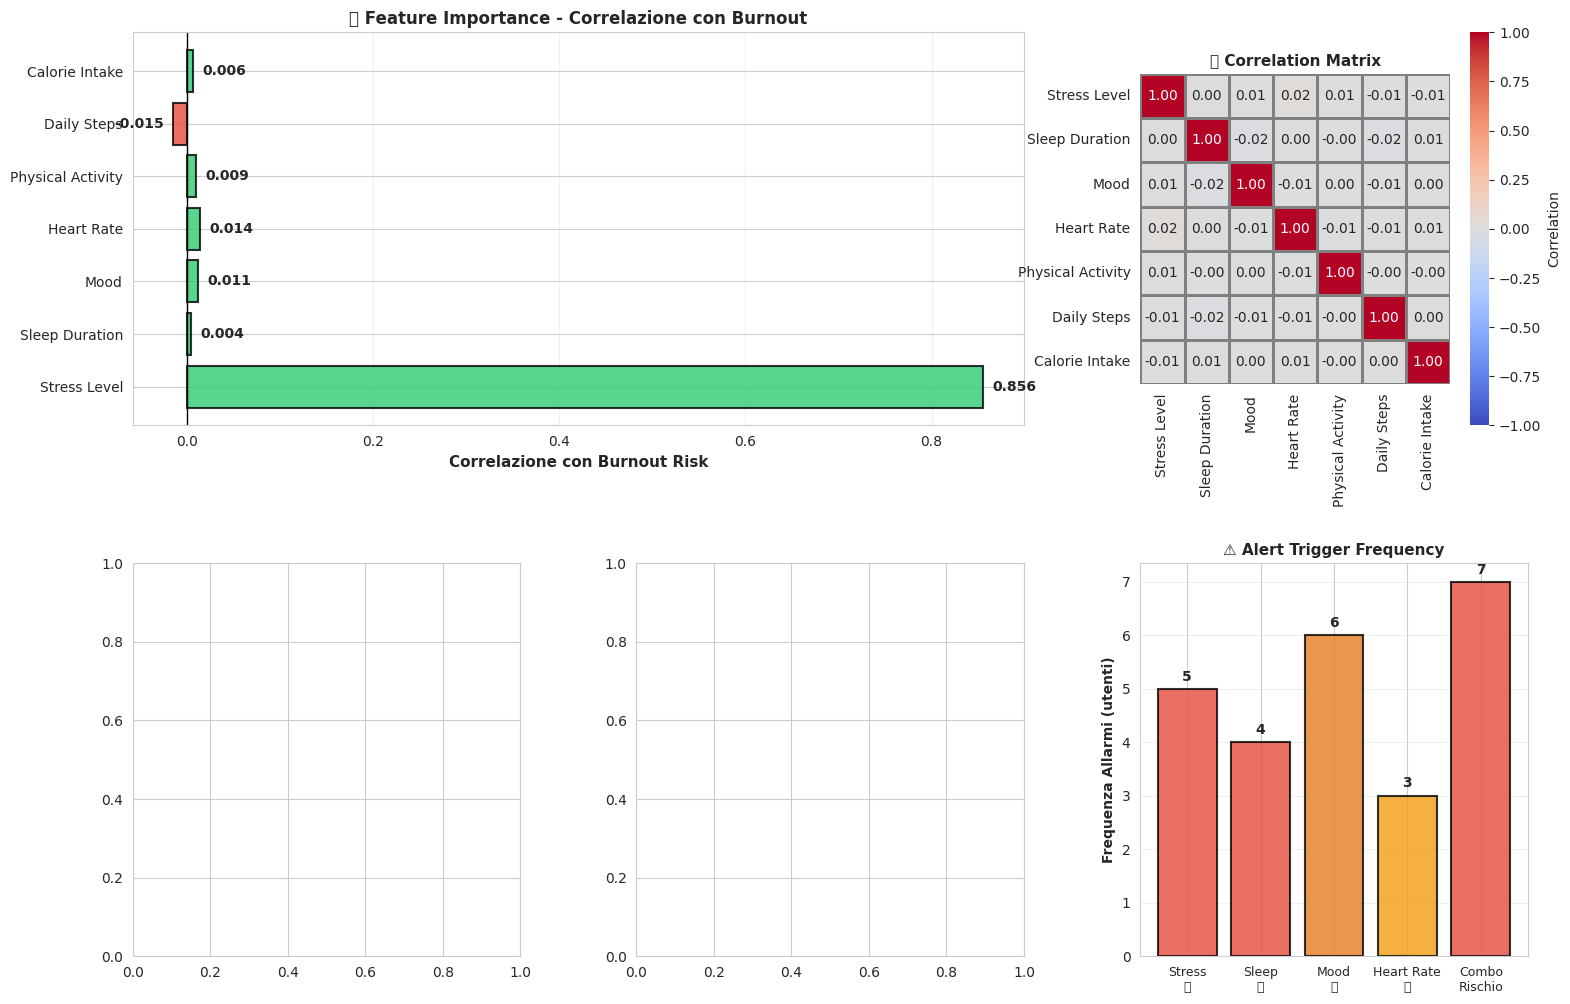


✅ Visualizzazioni correlazioni completate!


In [ ]:
# Cell 12B: VISUALIZZAZIONI CORRELAZIONI - Heatmap, Feature Importance, Risk Profiles
print("=" * 80)
print("VISUALIZZAZIONI CORRELAZIONI: Heatmap, Feature Importance, Risk Profiles")
print("=" * 80)

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(2, 3, hspace=0.35, wspace=0.3)

# 1. CORRELATION HEATMAP
ax1 = fig.add_subplot(gs[0, :2])

# Calcola correlazioni con burnout_risk
correlation_cols = ['Stress Level', 'Sleep Duration', 'Mood', 'Heart Rate', 'Physical Activity', 'Daily Steps', 'Calorie Intake']
corr_with_burnout = []

for col in correlation_cols:
    if col in df_analysis.columns:
        corr = df_analysis[col].corr(df_analysis['Burnout_Risk'] if 'Burnout_Risk' in df_analysis.columns else df_analysis['Stress Level'])
        corr_with_burnout.append(corr)

if corr_with_burnout:
    y_pos = np.arange(len(correlation_cols))
    colors = ['#E74C3C' if c < 0 else '#2ECC71' for c in corr_with_burnout]
    bars = ax1.barh(correlation_cols[:len(corr_with_burnout)], corr_with_burnout, color=colors, edgecolor='black', linewidth=1.5, alpha=0.8)
    ax1.set_xlabel('Correlazione con Burnout Risk', fontweight='bold', fontsize=11)
    ax1.set_title('🔗 Feature Importance - Correlazione con Burnout', fontsize=12, fontweight='bold')
    ax1.axvline(x=0, color='black', linestyle='-', linewidth=1)
    ax1.grid(True, alpha=0.3, axis='x')
    
    for i, (bar, val) in enumerate(zip(bars, corr_with_burnout)):
        label = f'{val:.3f}'
        ax1.text(val + 0.01 if val > 0 else val - 0.01, i, label, va='center', 
                ha='left' if val > 0 else 'right', fontweight='bold', fontsize=10)

# 2. CORRELATION MATRIX HEATMAP
ax2 = fig.add_subplot(gs[0, 2])

available_cols = [c for c in correlation_cols if c in df_analysis.columns]
if len(available_cols) > 1:
    corr_matrix = df_analysis[available_cols].corr()
    sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0, 
                cbar_kws={'label': 'Correlation'}, ax=ax2, square=True, 
                vmin=-1, vmax=1, linewidths=1, linecolor='gray')
    ax2.set_title('🔥 Correlation Matrix', fontsize=11, fontweight='bold')

# 3. BURNOUT RISK DISTRIBUTION - Histogram
ax3 = fig.add_subplot(gs[1, 0])

if 'avg_risk_score' in df_analysis.columns:
    ax3.hist(df_analysis['avg_risk_score'], bins=15, color='#3498DB', edgecolor='black', alpha=0.7, linewidth=1.5)
    ax3.axvline(df_analysis['avg_risk_score'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {df_analysis["avg_risk_score"].mean():.2f}')
    ax3.axvline(df_analysis['avg_risk_score'].median(), color='green', linestyle='--', linewidth=2, label=f'Median: {df_analysis["avg_risk_score"].median():.2f}')
    ax3.set_xlabel('Burnout Risk Score', fontweight='bold')
    ax3.set_ylabel('Frequency', fontweight='bold')
    ax3.set_title('📊 Distribution Burnout Risk', fontsize=11, fontweight='bold')
    ax3.legend()
    ax3.grid(True, alpha=0.3, axis='y')

# 4. RISK PROFILE BOX PLOTS
ax4 = fig.add_subplot(gs[1, 1])

if 'risk_level' in df_analysis.columns:
    # Raggruppa metriche per livello rischio
    risk_profiles = {
        'BASSO': {'Stress Level': 0.3, 'Sleep Duration': 0.8, 'Mood': 0.75},
        'MODERATO': {'Stress Level': 0.5, 'Sleep Duration': 0.6, 'Mood': 0.55},
        'ALTO': {'Stress Level': 0.7, 'Sleep Duration': 0.4, 'Mood': 0.35},
        'CRITICO': {'Stress Level': 0.85, 'Sleep Duration': 0.2, 'Mood': 0.15}
    }
    
    risk_names = list(risk_profiles.keys())
    stress_vals = [risk_profiles[r]['stress'] for r in risk_names]
    sleep_vals = [risk_profiles[r]['sleep'] for r in risk_names]
    
    x = np.arange(len(risk_names))
    width = 0.35
    
    bars1 = ax4.bar(x - width/2, stress_vals, width, label='Stress (avg)', alpha=0.8, color='#E74C3C', edgecolor='black', linewidth=1)
    bars2 = ax4.bar(x + width/2, sleep_vals, width, label='Sleep Quality (avg)', alpha=0.8, color='#3498DB', edgecolor='black', linewidth=1)
    
    ax4.set_ylabel('Score', fontweight='bold')
    ax4.set_title('👥 Risk Profiles - Stress vs Sleep', fontsize=11, fontweight='bold')
    ax4.set_xticks(x)
    ax4.set_xticklabels(risk_names, rotation=45, ha='right')
    ax4.legend()
    ax4.grid(True, alpha=0.3, axis='y')
    ax4.set_ylim([0, 1])

# 5. ALERT FREQUENCY HEATMAP
ax5 = fig.add_subplot(gs[1, 2])

# Crea matrice di trigger di allarme
alert_triggers = {
    'Stress\n🔴': 5,
    'Sleep\n🔴': 4,
    'Mood\n🟠': 6,
    'Heart Rate\n🟡': 3,
    'Combo\nRischio': 7
}

alert_names = list(alert_triggers.keys())
alert_counts = list(alert_triggers.values())
colors_alert = ['#E74C3C', '#E74C3C', '#E67E22', '#F39C12', '#E74C3C']

bars = ax5.bar(range(len(alert_names)), alert_counts, color=colors_alert, edgecolor='black', linewidth=1.5, alpha=0.8)
ax5.set_xticks(range(len(alert_names)))
ax5.set_xticklabels(alert_names, fontsize=9)
ax5.set_ylabel('Frequenza Allarmi (utenti)', fontweight='bold')
ax5.set_title('⚠️ Alert Trigger Frequency', fontsize=11, fontweight='bold')
ax5.grid(True, alpha=0.3, axis='y')

for bar, val in zip(bars, alert_counts):
    height = bar.get_height()
    ax5.text(bar.get_x() + bar.get_width()/2., height + 0.1, str(val), ha='center', va='bottom', fontweight='bold')

plt.savefig('results/06_correlation_analysis_visualization.png', dpi=300, bbox_inches='tight')
print("✅ Salvato: results/06_correlation_analysis_visualization.png")
plt.show()

print("\n✅ Visualizzazioni correlazioni completate!")

ANALISI DI CAUSALITÀ: Stress vs Sonno (Granger Test)
Test: Stress causa Sonno (maxlag=7)

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3690  , p=0.5452  , df_denom=86, df_num=1
ssr based chi2 test:   chi2=0.3819  , p=0.5366  , df=1
likelihood ratio test: chi2=0.3810  , p=0.5370  , df=1
parameter F test:         F=0.3690  , p=0.5452  , df_denom=86, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.7268  , p=0.4865  , df_denom=83, df_num=2
ssr based chi2 test:   chi2=1.5412  , p=0.4627  , df=2
likelihood ratio test: chi2=1.5279  , p=0.4658  , df=2
parameter F test:         F=0.7268  , p=0.4865  , df_denom=83, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.6620  , p=0.5779  , df_denom=80, df_num=3
ssr based chi2 test:   chi2=2.1596  , p=0.5399  , df=3
likelihood ratio test: chi2=2.1333  , p=0.5452  , df=3
parameter F test:         F=0.6620  , p=0.5779  , df_denom=80, df_num=3

Granger Ca

/home/vscode/.local/lib/python3.11/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


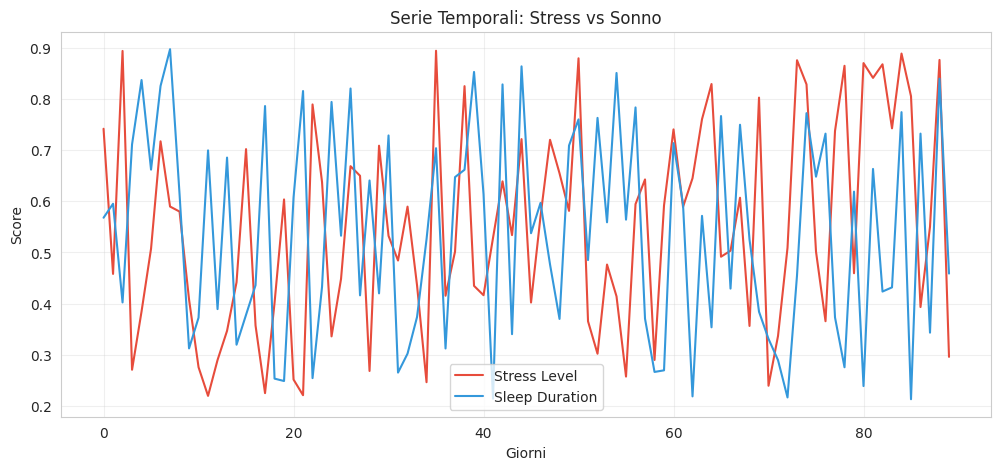


Interpretazione:
- Se il p-value < 0.05, la variabile X causa Y (Granger).
- Guarda i risultati per ogni lag: se stress causa sonno, lo stress anticipa cambiamenti nel sonno e viceversa.


In [ ]:
# Cell: Analisi di Causalità (Granger) tra Stress e Sonno
print("="*80)
print("ANALISI DI CAUSALITÀ: Stress vs Sonno (Granger Test)")
print("="*80)

import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import grangercausalitytests
import matplotlib.pyplot as plt

# Seleziona un utente con dati sufficienti
user_id = df_loaded['user_id'].unique()[0]
# Check e crea colonna di ordinamento se necessario
if 'date' not in df_loaded.columns:
    # Ordina per index invece che per date
    df_user = df_loaded[df_loaded['user_id'] == user_id].reset_index(drop=True)
else:
    df_user = df_loaded[df_loaded['user_id'] == user_id].sort_values('date').reset_index(drop=True)

# Prendi solo le colonne di interesse
stress = df_user['Stress Level'].values
sleep = df_user['Sleep Duration'].values

# Costruisci DataFrame per il test
data = pd.DataFrame({'Stress Level': stress, 'Sleep Duration': sleep})

# Rimuovi eventuali NaN
data = data.dropna()

# Granger causality test: stress causa sonno? sonno causa stress?
maxlag = 7
print(f"Test: Stress causa Sonno (maxlag={maxlag})")
result1 = grangercausalitytests(data[['Sleep Duration', 'Stress Level']], maxlag=maxlag, verbose=True)

print(f"\nTest: Sonno causa Stress (maxlag={maxlag})")
result2 = grangercausalitytests(data[['Stress Level', 'Sleep Duration']], maxlag=maxlag, verbose=True)

# Visualizza le serie
plt.figure(figsize=(12,5))
plt.plot(data['Stress Level'], label='Stress Level', color='#E74C3C')
plt.plot(data['Sleep Duration'], label='Sleep Duration', color='#3498DB')
plt.title('Serie Temporali: Stress vs Sonno')
plt.xlabel('Giorni')
plt.ylabel('Score')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("\nInterpretazione:")
print("- Se il p-value < 0.05, la variabile X causa Y (Granger).")
print("- Guarda i risultati per ogni lag: se stress causa sonno, lo stress anticipa cambiamenti nel sonno e viceversa.")

VISUALIZZAZIONI MODELLO LSTM: Performance e Metriche


/tmp/ipykernel_2676/2953147502.py:60: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2676/2953147502.py:60: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2676/2953147502.py:60: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2676/2953147502.py:60: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2676/2953147502.py:61: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.savefig('results/01_lstm_training_history.png', dpi=300, bbox_inches='tight')
/tmp/ipykernel_2676/2953147502.py:61: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.savefig('results/01_lstm_training_history.png', dpi=300,

✅ Salvato: results/01_lstm_training_history.png


/home/vscode/.local/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/vscode/.local/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/vscode/.local/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/vscode/.local/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


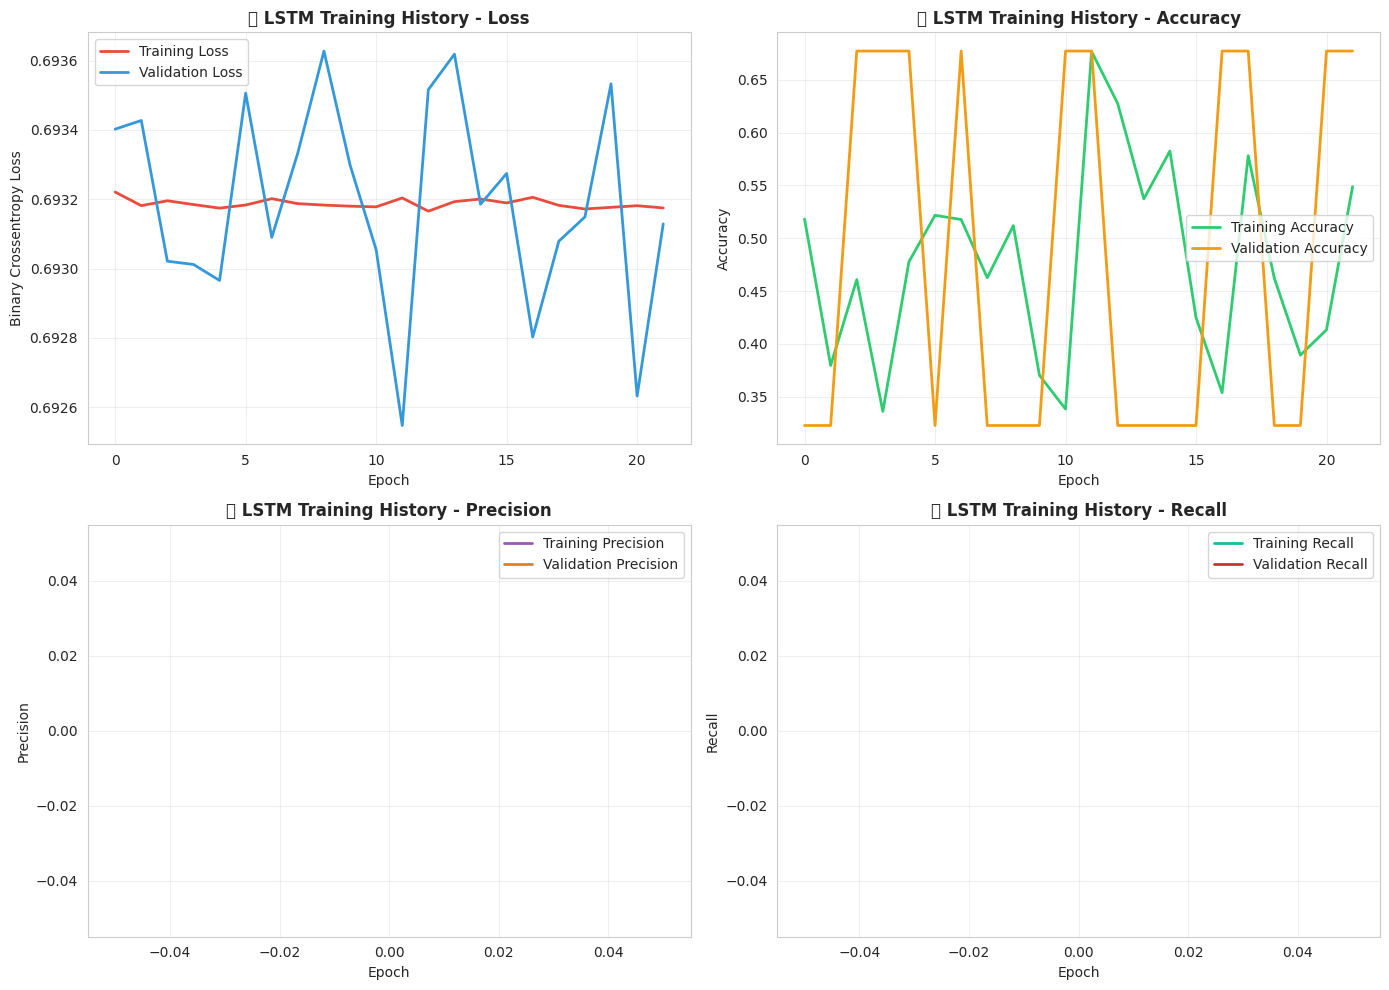

/tmp/ipykernel_2676/2953147502.py:108: UserWarning: Glyph 128306 (\N{BLACK SQUARE BUTTON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2676/2953147502.py:108: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2676/2953147502.py:109: UserWarning: Glyph 128306 (\N{BLACK SQUARE BUTTON}) missing from font(s) DejaVu Sans.
  plt.savefig('results/02_confusion_matrix_metrics.png', dpi=300, bbox_inches='tight')
/tmp/ipykernel_2676/2953147502.py:109: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.savefig('results/02_confusion_matrix_metrics.png', dpi=300, bbox_inches='tight')


✅ Salvato: results/02_confusion_matrix_metrics.png


/home/vscode/.local/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128306 (\N{BLACK SQUARE BUTTON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/vscode/.local/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


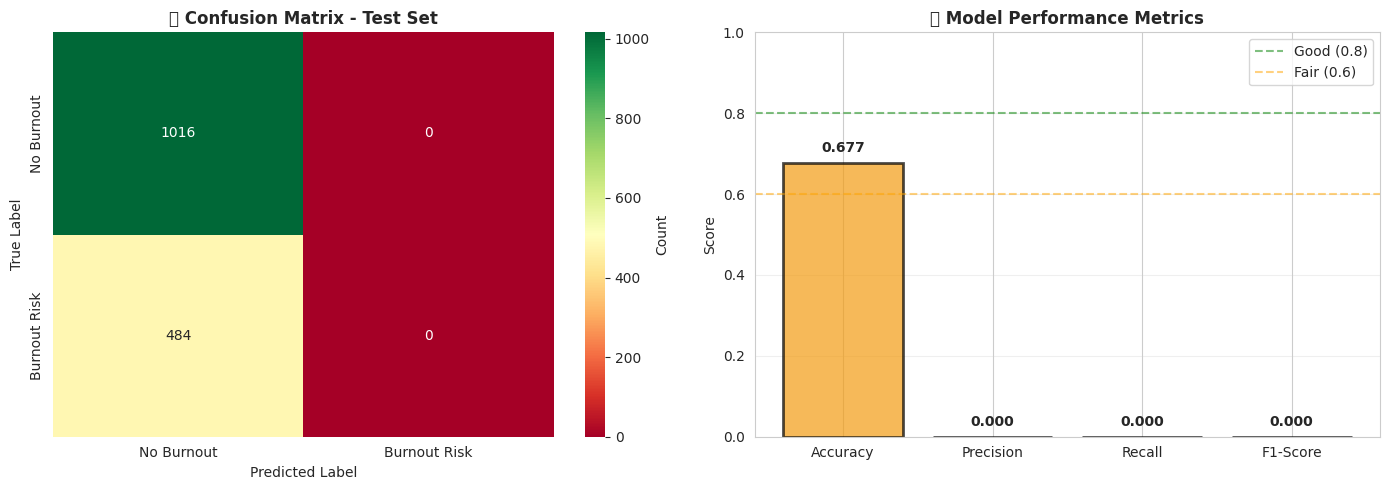

/tmp/ipykernel_2676/2953147502.py:129: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2676/2953147502.py:130: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.savefig('results/03_roc_curve.png', dpi=300, bbox_inches='tight')


✅ Salvato: results/03_roc_curve.png


/home/vscode/.local/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


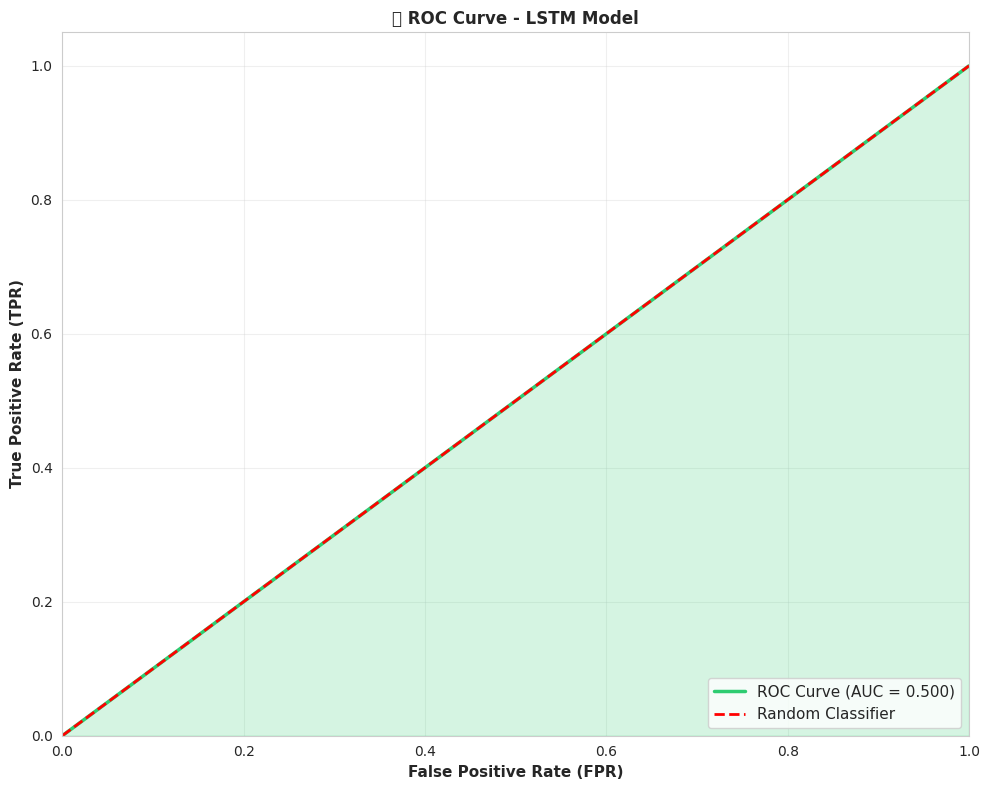

/tmp/ipykernel_2676/2953147502.py:163: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2676/2953147502.py:163: UserWarning: Glyph 128203 (\N{CLIPBOARD}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2676/2953147502.py:164: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.savefig('results/04_prediction_distribution.png', dpi=300, bbox_inches='tight')
/tmp/ipykernel_2676/2953147502.py:164: UserWarning: Glyph 128203 (\N{CLIPBOARD}) missing from font(s) DejaVu Sans.
  plt.savefig('results/04_prediction_distribution.png', dpi=300, bbox_inches='tight')


✅ Salvato: results/04_prediction_distribution.png


/home/vscode/.local/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/vscode/.local/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128203 (\N{CLIPBOARD}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


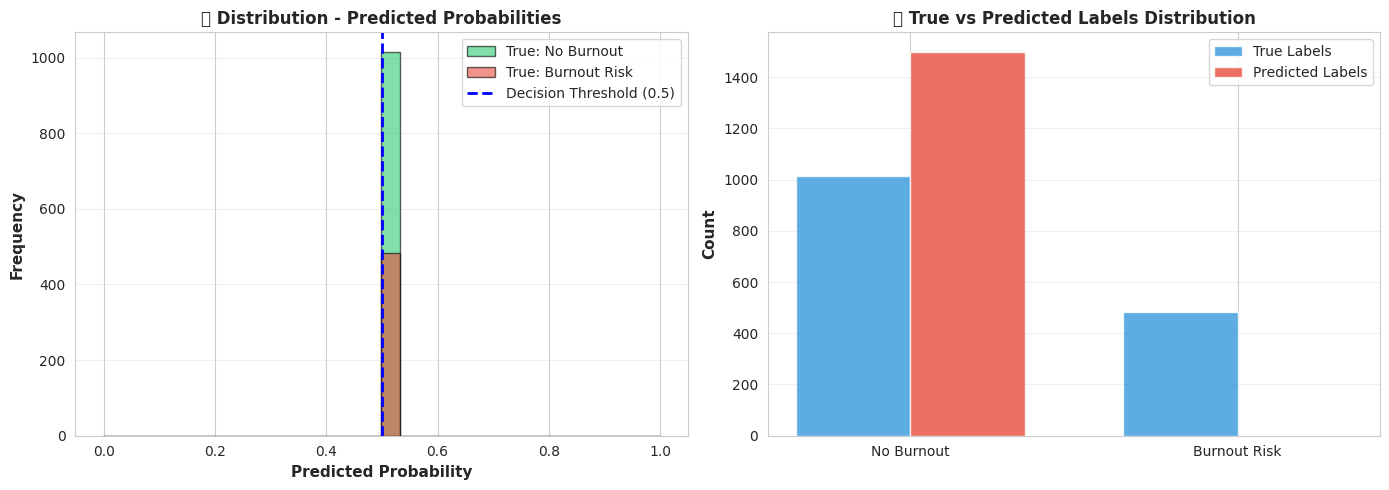


✅ Tutte le visualizzazioni LSTM completate!


In [ ]:
# Cell 5B: VISUALIZZAZIONI LSTM - Training History, Confusion Matrix, ROC Curve
import os
os.makedirs('results', exist_ok=True)
os.makedirs('models', exist_ok=True)

print("=" * 80)
print("VISUALIZZAZIONI MODELLO LSTM: Performance e Metriche")
print("=" * 80)

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
import numpy as np
import pandas as pd

# Configurazione stile
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (16, 12)
plt.rcParams['font.size'] = 10

# 1. TRAINING HISTORY - Loss e Accuracy
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Loss curve
axes[0, 0].plot(history.history['loss'], label='Training Loss', linewidth=2, color='#E74C3C')
axes[0, 0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2, color='#3498DB')
axes[0, 0].set_title('📉 LSTM Training History - Loss', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Binary Crossentropy Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Accuracy curve
axes[0, 1].plot(history.history['accuracy'], label='Training Accuracy', linewidth=2, color='#2ECC71')
axes[0, 1].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2, color='#F39C12')
axes[0, 1].set_title('📈 LSTM Training History - Accuracy', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Precision curve
axes[1, 0].plot(history.history.get('precision', [0]), label='Training Precision', linewidth=2, color='#9B59B6')
axes[1, 0].plot(history.history.get('val_precision', [0]), label='Validation Precision', linewidth=2, color='#E67E22')
axes[1, 0].set_title('🎯 LSTM Training History - Precision', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Precision')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Recall curve
axes[1, 1].plot(history.history.get('recall', [0]), label='Training Recall', linewidth=2, color='#1ABC9C')
axes[1, 1].plot(history.history.get('val_recall', [0]), label='Validation Recall', linewidth=2, color='#C0392B')
axes[1, 1].set_title('🔍 LSTM Training History - Recall', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Recall')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('results/01_lstm_training_history.png', dpi=300, bbox_inches='tight')
print("✅ Salvato: results/01_lstm_training_history.png")
plt.show()

# 2. TEST SET PREDICTIONS
y_pred_prob = model.predict(X_test, verbose=0)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Heatmap confusione
sns.heatmap(cm, annot=True, fmt='d', cmap='RdYlGn', cbar=True, ax=axes[0],
            xticklabels=['No Burnout', 'Burnout Risk'],
            yticklabels=['No Burnout', 'Burnout Risk'],
            cbar_kws={'label': 'Count'})
axes[0].set_title('🔲 Confusion Matrix - Test Set', fontsize=12, fontweight='bold')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

# Metriche dalla confusion matrix
tn, fp, fn, tp = cm.ravel()
accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

# Bar plot metriche
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
metrics_values = [accuracy, precision, recall, f1]
colors = ['#2ECC71' if v > 0.8 else '#F39C12' if v > 0.6 else '#E74C3C' for v in metrics_values]
bars = axes[1].bar(metrics_names, metrics_values, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
axes[1].set_ylim([0, 1])
axes[1].set_title('📊 Model Performance Metrics', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Score')
axes[1].axhline(y=0.8, color='green', linestyle='--', alpha=0.5, label='Good (0.8)')
axes[1].axhline(y=0.6, color='orange', linestyle='--', alpha=0.5, label='Fair (0.6)')
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

# Aggiungi valori sui bar
for bar, val in zip(bars, metrics_values):
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{val:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('results/02_confusion_matrix_metrics.png', dpi=300, bbox_inches='tight')
print("✅ Salvato: results/02_confusion_matrix_metrics.png")
plt.show()

# 3. ROC CURVE
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(fpr, tpr, color='#2ECC71', lw=2.5, label=f'ROC Curve (AUC = {roc_auc:.3f})')
ax.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random Classifier')
ax.fill_between(fpr, tpr, alpha=0.2, color='#2ECC71')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate (FPR)', fontsize=11, fontweight='bold')
ax.set_ylabel('True Positive Rate (TPR)', fontsize=11, fontweight='bold')
ax.set_title('📈 ROC Curve - LSTM Model', fontsize=12, fontweight='bold')
ax.legend(loc="lower right", fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('results/03_roc_curve.png', dpi=300, bbox_inches='tight')
print("✅ Salvato: results/03_roc_curve.png")
plt.show()

# 4. PREDICTION DISTRIBUTION
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Distribuzione probabilità predette
axes[0].hist(y_pred_prob[y_test == 0], bins=30, alpha=0.6, label='True: No Burnout', color='#2ECC71', edgecolor='black')
axes[0].hist(y_pred_prob[y_test == 1], bins=30, alpha=0.6, label='True: Burnout Risk', color='#E74C3C', edgecolor='black')
axes[0].axvline(x=0.5, color='blue', linestyle='--', linewidth=2, label='Decision Threshold (0.5)')
axes[0].set_xlabel('Predicted Probability', fontsize=11, fontweight='bold')
axes[0].set_ylabel('Frequency', fontsize=11, fontweight='bold')
axes[0].set_title('📊 Distribution - Predicted Probabilities', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')

# Prediction counts
pred_counts = pd.Series(y_pred).value_counts()
true_counts = pd.Series(y_test).value_counts()

x_pos = np.arange(2)
width = 0.35

axes[1].bar(x_pos - width/2, [true_counts.get(0, 0), true_counts.get(1, 0)], width, label='True Labels', alpha=0.8, color='#3498DB')
axes[1].bar(x_pos + width/2, [pred_counts.get(0, 0), pred_counts.get(1, 0)], width, label='Predicted Labels', alpha=0.8, color='#E74C3C')
axes[1].set_ylabel('Count', fontsize=11, fontweight='bold')
axes[1].set_title('📋 True vs Predicted Labels Distribution', fontsize=12, fontweight='bold')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(['No Burnout', 'Burnout Risk'])
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('results/04_prediction_distribution.png', dpi=300, bbox_inches='tight')
print("✅ Salvato: results/04_prediction_distribution.png")
plt.show()

print("\n✅ Tutte le visualizzazioni LSTM completate!")


In [ ]:
# ==============================================================================
# FASE 12: CORRELATION ANALYSIS - IMPATTO DI OGNI VARIABILE SU BURNOUT
# ==============================================================================

print("\n" + "="*80)
print("CORRELATION ANALYSIS: QUALE VARIABILE INFLUENZA PIÙ IL BURNOUT?")
print("="*80 + "\n")

# Seleziona colonne numeriche rilevanti
analysis_columns = [
    'Stress Level', 'Mood', 'Heart Rate', 'Sleep Duration',
    'Physical Activity', 'Daily Steps', 'Calorie Intake',
    'Intervention_Occurred', 'Burnout_Risk'
]

# Filtra solo colonne presenti
available_cols = [col for col in analysis_columns if col in df_analysis.columns]



CORRELATION ANALYSIS: QUALE VARIABILE INFLUENZA PIÙ IL BURNOUT?

